# IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from IPython.display import Image, display
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import kendalltau
from statsmodels.tsa.api import VAR

# INTRODUCTION TO THE DATASET

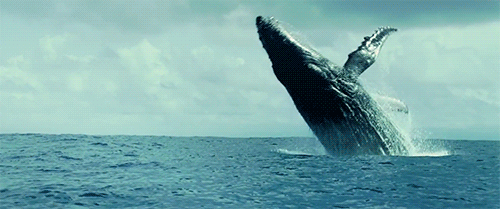

In [31]:
from IPython.display import Image, display
filename = "C:\\Users\\FLAME\\Downloads\\Whale_Flappinig.gif"
display(Image(filename))

 ## Overview

Whales are essential marine mammals that significantly contribute to maintaining the health of ocean ecosystems. One of the most vital aspects of whale behavior is their migration. Whale migration is driven by a variety of factors, such as seasonality, environmental conditions, and food availability. However, predicting the exact migration patterns of whales is a highly complex task, as it involves multiple dynamic and interrelated environmental variables.

Accurately predicting whale migration patterns is crucial for marine biologists, conservationists, and environmental agencies to monitor whale populations, track their movements, and take appropriate conservation actions. Whale migration prediction is particularly important for mitigating threats from human activities, such as shipping routes, oil exploration, and the impacts of climate change.

## Objective

The primary objective of this study is to develop a time series forecasting model that predicts whale migration patterns.

This model will help researchers and conservationists better understand the factors that influence whale migration and allow for more effective tracking of their movements. It will also provide the foundation for informed decision-making in conservation efforts.

## Target Variable: Number of Sightings

## Dataset Overview

**Date**

Description: A time-based index (either daily, weekly, or monthly).

Purpose: To track the sighting data over time.

**Number of Sightings**

Description: The count of whale sightings at a particular location on a given day, week, or month.

Purpose: This is the target variable that we aim to predict.

**Location**

Description: Latitude and longitude of the whale sighting location.

Purpose: To track the spatial distribution of whale sightings over time.

**Sea Surface Temperature**

Description: The temperature of the ocean surface at the time of sighting.

Purpose: SST influences whale behavior and migration patterns, making it an important feature.

**Ocean Currents**

Description: Direction and speed of ocean currents at the time of sighting.

Purpose: Ocean currents impact whale migration paths and help guide their movement.

**Chlorophyll Concentration**

Description: A measure of the plankton availability (food source for whales).

Purpose: This variable is crucial for understanding food availability, which influences migration.

**Season**

Description: The season during which the sighting occurred (Winter, Spring, Summer, Autumn).

Purpose: Seasonality can have a major effect on whale migration patterns.

**Moon Phases**

Description: The phase of the moon during the sighting.

Purpose: Some studies suggest that moon phases may alter whale behavior and migration.

**Wind Speed**

Description: Wind speed at the time of sighting.

Purpose: Wind conditions can affect ocean currents and, in turn, whale movements.

**Human Activity**

Description: A binary feature indicating the presence of human activities nearby (e.g., ships, oil rigs).

Purpose: Human activities can disrupt migration patterns, making it important to track.

# EXPLORATORY DATA ANALYSIS

## Initial Exploration

Dataset Upload and Initial Loading

In [32]:
filename = "C:\\Users\\FLAME\\Downloads\\synthetic_whale_migration_data.csv"

df = pd.read_csv(filename)
df.head()

Date  Latitude  Longitude  Whale_Sightings  Sea_Surface_Temperature  \
0  1900-01-01     82.06     -25.62               22                    10.36   
1  1900-01-02    -29.26     130.33               11                    28.78   
2  1900-01-03     78.10     117.66                8                    28.67   
3  1900-01-04    -43.31      -5.62                8                    22.79   
4  1900-01-05     40.51     129.80               20                    18.85   

   Ocean_Current  Chlorophyll_Concentration     Moon_Phase  Human_Activity  
0           0.01                       7.07      Full Moon               0  
1           1.64                       0.91   Last Quarter               0  
2           2.86                       7.60       New Moon               0  
3           2.99                       0.69   Last Quarter               0  
4           2.45                       6.41  First Quarter               0

Dataset Summary

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45291 entries, 0 to 45290
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       45291 non-null  object 
 1   Latitude                   45291 non-null  float64
 2   Longitude                  45291 non-null  float64
 3   Whale_Sightings            45291 non-null  int64  
 4   Sea_Surface_Temperature    45291 non-null  float64
 5   Ocean_Current              45291 non-null  float64
 6   Chlorophyll_Concentration  45291 non-null  float64
 7   Moon_Phase                 45291 non-null  object 
 8   Human_Activity             45291 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 3.1+ MB


*dataset does not contain any empty values*

Duplicate Row Detection

In [34]:
df.duplicated().sum()

np.int64(0)

Identifying Data Types

In [35]:
column_roles = []

for col in df.columns:
    dtype = df[col].dtype

    if pd.api.types.is_numeric_dtype(dtype):
        role = 'Numerical'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        role = 'Datetime'
    elif pd.api.types.is_object_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype):
        role = 'Categorical'
    else:
        role = 'Other'

    column_roles.append({'Column': col, 'Role': role, 'Data Type': dtype})

column_roles_df = pd.DataFrame(column_roles)
print(column_roles_df)

                      Column         Role Data Type
0                       Date  Categorical    object
1                   Latitude    Numerical   float64
2                  Longitude    Numerical   float64
3            Whale_Sightings    Numerical     int64
4    Sea_Surface_Temperature    Numerical   float64
5              Ocean_Current    Numerical   float64
6  Chlorophyll_Concentration    Numerical   float64
7                 Moon_Phase  Categorical    object
8             Human_Activity    Numerical     int64


## Data Preprocessing

Datetime Conversion of the Date Column

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Label Encoding of the Moon_Phase Variable

In [37]:
moon_phase_values = df['Moon_Phase'].unique()
print(moon_phase_values)

['Full Moon' 'Last Quarter' 'New Moon' 'First Quarter']


In [39]:
label_encoder = LabelEncoder()

df['Moon_Phase_Encoded'] = label_encoder.fit_transform(df['Moon_Phase'])

moon_phase_encoding_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Moon Phase Encoding Map:")
print(moon_phase_encoding_map)

Moon Phase Encoding Map:
{'First Quarter': np.int64(0), 'Full Moon': np.int64(1), 'Last Quarter': np.int64(2), 'New Moon': np.int64(3)}


Verifying Data Types

In [40]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45291 entries, 1900-01-01 to 2024-01-01
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Latitude                   45291 non-null  float64
 1   Longitude                  45291 non-null  float64
 2   Whale_Sightings            45291 non-null  int64  
 3   Sea_Surface_Temperature    45291 non-null  float64
 4   Ocean_Current              45291 non-null  float64
 5   Chlorophyll_Concentration  45291 non-null  float64
 6   Moon_Phase                 45291 non-null  object 
 7   Human_Activity             45291 non-null  int64  
 8   Moon_Phase_Encoded         45291 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 3.5+ MB
None


## Data Distribution and Temporal Patterns

Descriptive Statistics

In [43]:
df.describe(include=[np.number])

Latitude     Longitude  Whale_Sightings  Sea_Surface_Temperature  \
count  45291.000000  45291.000000     45291.000000             45291.000000   
mean       0.150473      0.032904        16.620565                19.970116   
std       51.949935    103.507318         6.469611                 5.769618   
min      -89.990000   -179.990000         5.000000                10.000000   
25%      -44.690000    -89.470000        11.000000                14.960000   
50%        0.350000     -0.180000        17.000000                19.980000   
75%       45.370000     88.870000        22.000000                24.960000   
max       89.980000    179.990000        30.000000                30.000000   

       Ocean_Current  Chlorophyll_Concentration  Human_Activity  \
count   45291.000000               45291.000000    45291.000000   
mean        2.502036                   5.061438        0.097746   
std         1.441804                   2.855008        0.296974   
min         0.000000                   0.100000        0.000000   
25%         1.250000                   2.600000        0.000000   
50%         2.500000                   5.090000        0.000000   
75%         3.740000                   7.530000        0.000000   
max         5.000000                  10.000000        1.000000   

       Moon_Phase_Encoded  
count        45291.000000  
mean             1.497649  
std              1.116216  
min              0.000000  
25%              1.000000  
50%              1.000000  
75%              2.000000  
max              3.000000

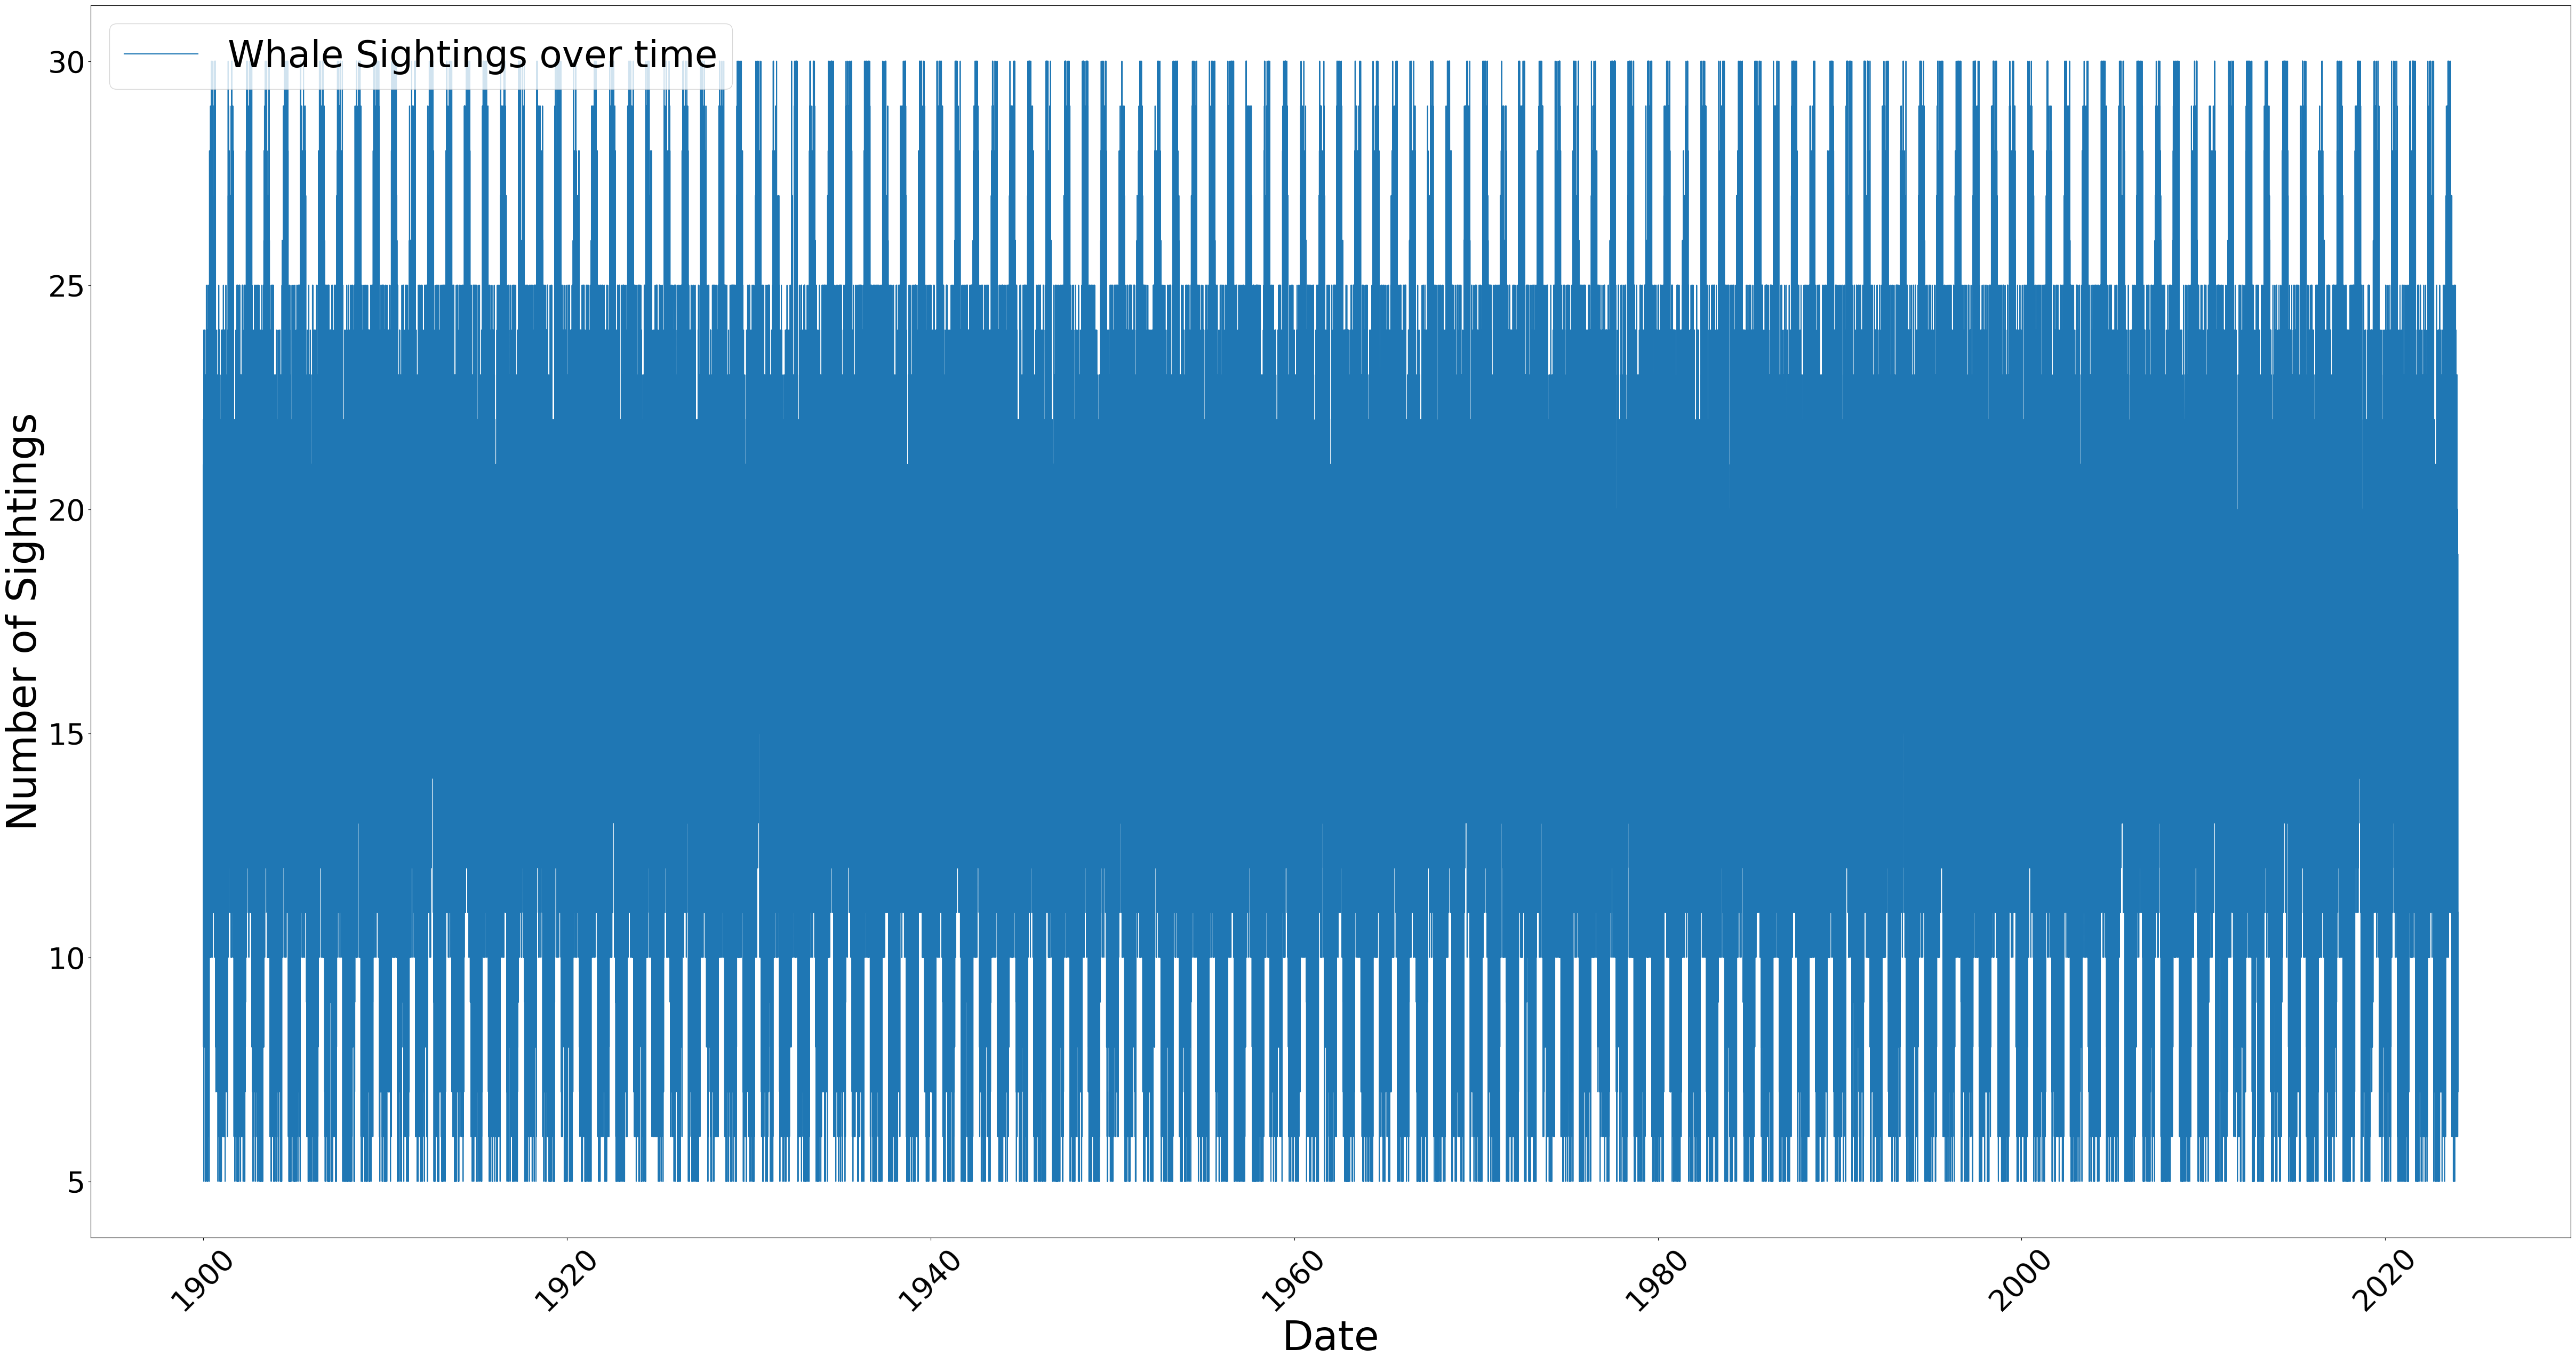

In [44]:
plt.figure(figsize=(60, 30))
plt.plot(df.index, df['Whale_Sightings'], label='Whale Sightings over time')

plt.xlabel('Date', fontsize=55)
plt.ylabel('Number of Sightings', fontsize=55)

plt.xticks(fontsize=40, rotation=45)
plt.yticks(fontsize=40)

plt.legend(fontsize=50)
plt.show()

Time Series Decomposition: Trend, Seasonality, and Residuals

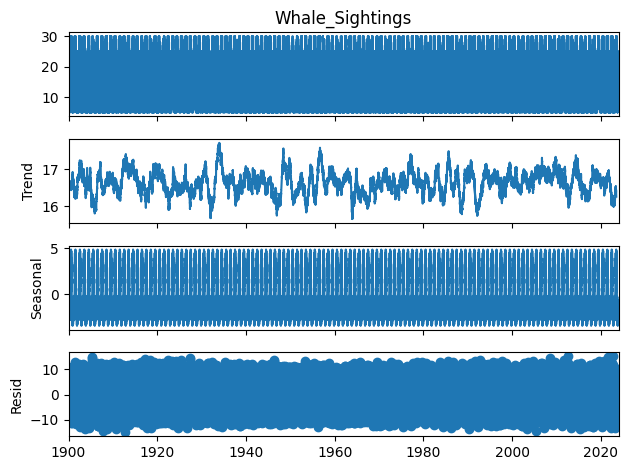

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Whale_Sightings'], model='additive', period=365)
decomposition.plot()
plt.show()

*The data exhibits a clear seasonal pattern with little to no long-term trend*

Stationarity Assessment using the ADF Test

In [46]:
result = adfuller(df['Whale_Sightings'].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

if result[1] < 0.05:
    print("Reject null hypothesis: The series is stationary")
else:
    print("Fail to reject null hypothesis: The series is not stationary")

ADF Statistic: -21.596271691167914
p-value: 0.0
Critical Values: {'1%': np.float64(-3.43049449118246), '5%': np.float64(-2.8616038619878026), '10%': np.float64(-2.5668039916496603)}
Reject null hypothesis: The series is stationary


*No Differencing Required Due to Stationarity*

### Evaluation of Trend and Seasonal Patterns

Mann-Kendall Test for Trend Detection

In [47]:
y = df['Whale_Sightings'].values

tau, p_value = kendalltau(np.arange(len(y)), y)

print(f'Mann-Kendall Tau: {tau:.4f}')
print(f'Mann-Kendall p-value: {p_value:.4f}')

if p_value < 0.05:
    if tau > 0:
        print("There is a significant upward trend in Whale Sightings.")
    elif tau < 0:
        print("There is a significant downward trend in Whale Sightings.")
else:
    print("No significant trend detected in Whale Sightings.")

Mann-Kendall Tau: 0.0015
Mann-Kendall p-value: 0.6376
No significant trend detected in Whale Sightings.


Fast Fourier Transform for Seasonal Fluctuations

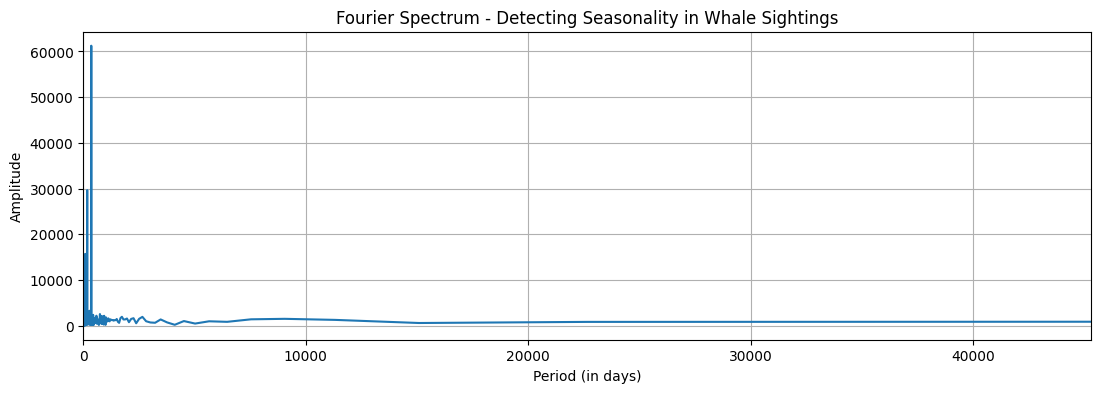

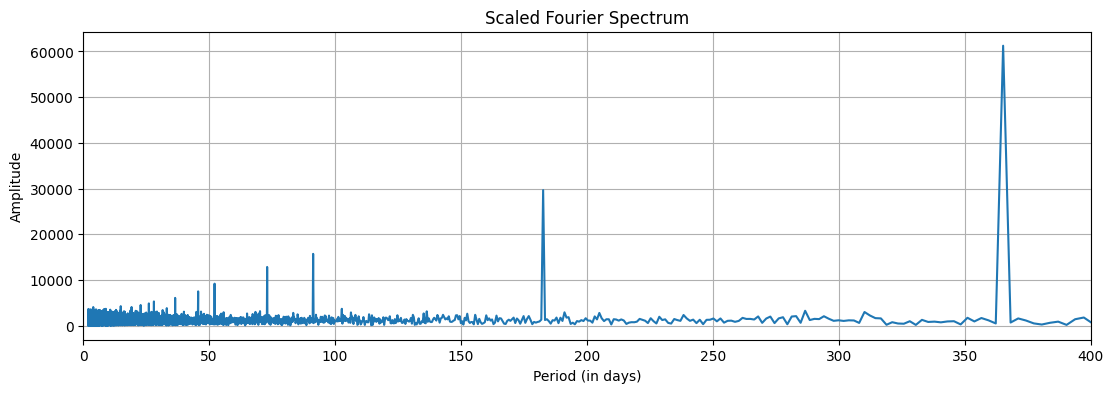

Dominant Seasonal Periods and Amplitudes:
Period: 365.25 days, Amplitude: 61253.41
Period: 182.62 days, Amplitude: 29668.38
Period: 91.31 days, Amplitude: 15720.71
Period: 73.05 days, Amplitude: 12855.40
Period: 52.18 days, Amplitude: 9203.64
Period: 45.66 days, Amplitude: 7515.35
Period: 36.52 days, Amplitude: 6088.38
Period: 28.10 days, Amplitude: 5314.90
Period: 26.09 days, Amplitude: 4882.13
Period: 22.83 days, Amplitude: 4536.41
Period: 14.92 days, Amplitude: 4282.14
Period: 19.22 days, Amplitude: 4097.90
Period: 4.01 days, Amplitude: 4086.36
Period: 33.20 days, Amplitude: 3846.47
Period: 102.70 days, Amplitude: 3704.14


In [48]:
y = df['Whale_Sightings'].values

y_detrended = y - np.mean(y)

# Fast Fourier Transform (FFT)
fft_vals = np.fft.fft(y_detrended)
fft_freqs = np.fft.fftfreq(len(y_detrended))

positive_freqs = fft_freqs[fft_freqs > 0]
positive_fft = np.abs(fft_vals[fft_freqs > 0])

periods = 1 / positive_freqs

dominant_periods_idx = np.argsort(positive_fft)[::-1][:15]
dominant_periods = periods[dominant_periods_idx]
dominant_amplitudes = positive_fft[dominant_periods_idx]

plt.figure(figsize=(13, 4))
plt.plot(periods, positive_fft)
plt.xlabel('Period (in days)')
plt.ylabel('Amplitude')
plt.title('Fourier Spectrum - Detecting Seasonality in Whale Sightings')
plt.grid(True)
plt.xlim(0, 45291) # number of entries in the dataset
plt.show()

plt.figure(figsize=(13, 4))
plt.plot(periods, positive_fft)
plt.xlabel('Period (in days)')
plt.ylabel('Amplitude')
plt.title('Scaled Fourier Spectrum')
plt.grid(True)
plt.xlim(0, 400)
plt.show()

print("Dominant Seasonal Periods and Amplitudes:")
for period, amplitude in zip(dominant_periods, dominant_amplitudes):
    print(f"Period: {period:.2f} days, Amplitude: {amplitude:.2f}")

*Given the presence of an annual cycle in the data, we will employ a lag of 365 days to effectively capture the underlying seasonal structure*

### Feauture Selection

Correlation Matrix

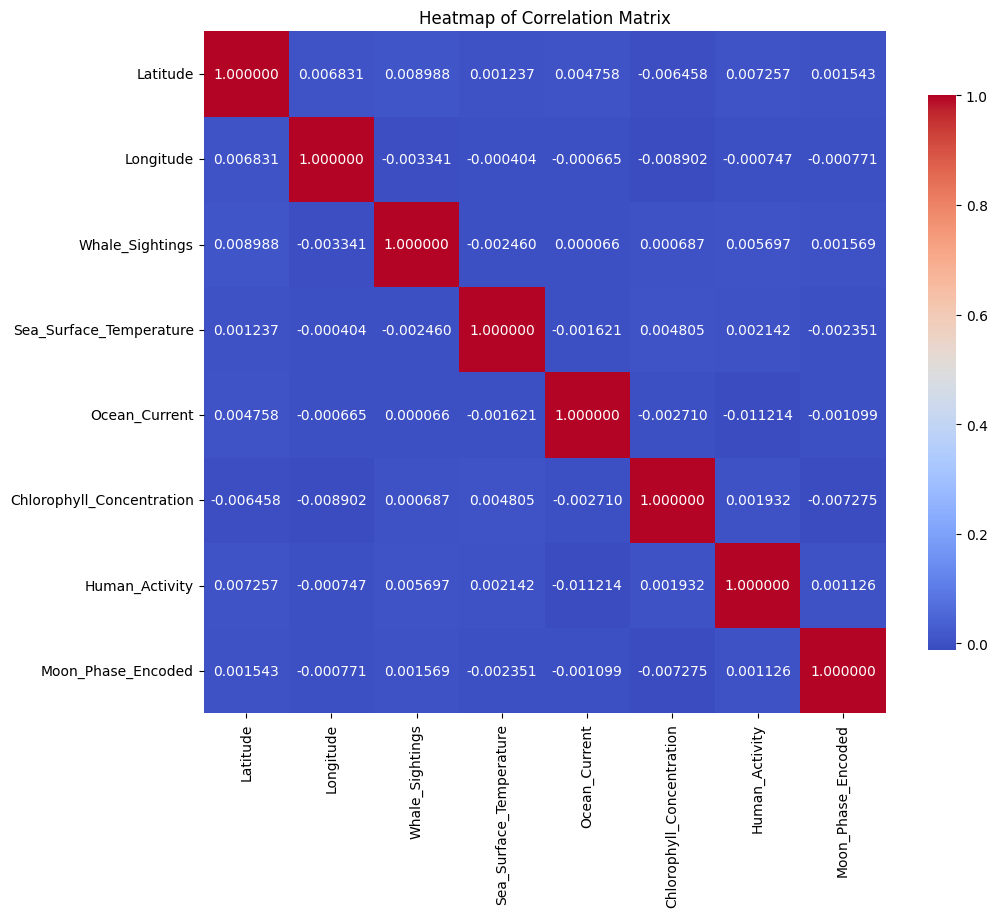

In [49]:
numerical_variables = df.select_dtypes(include=['float64', 'int64', 'int8']).columns

correlation_matrix = df[numerical_variables].corr()

plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, fmt=".6f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap of Correlation Matrix')
plt.show()

Random Forest Model

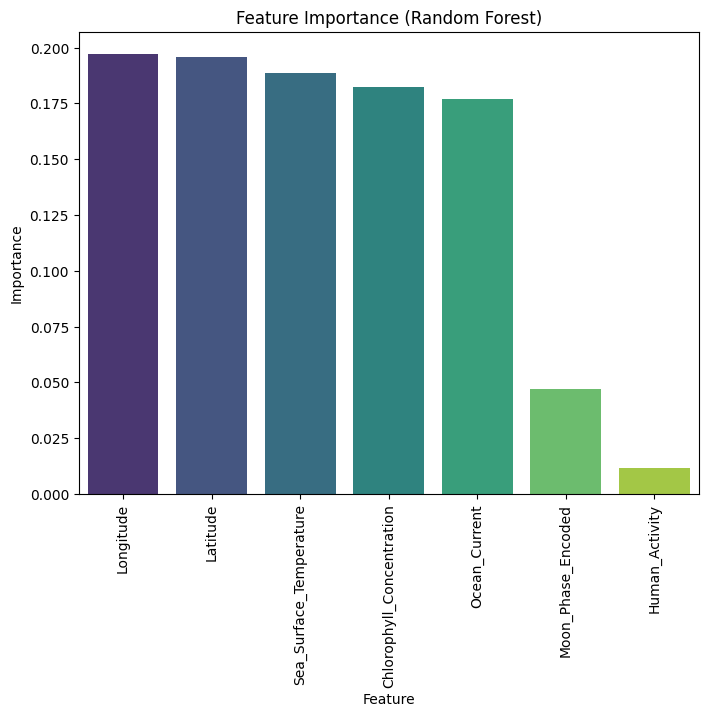

Most important features based on Random Forest importance:

                     Feature  Importance
1                  Longitude    0.197221
0                   Latitude    0.195804
2    Sea_Surface_Temperature    0.188611
4  Chlorophyll_Concentration    0.182566
3              Ocean_Current    0.177056
6         Moon_Phase_Encoded    0.046935
5             Human_Activity    0.011808


In [50]:
predictor_variables = [
    'Latitude', 'Longitude', 'Sea_Surface_Temperature', 'Ocean_Current',
    'Chlorophyll_Concentration', 'Human_Activity', 'Moon_Phase_Encoded'
]

X = df[predictor_variables]
y = df['Whale_Sightings']

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)

importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': predictor_variables,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance_df['Feature'], y=importance_df['Importance'], hue=importance_df['Feature'], palette="viridis", legend=False)
plt.title('Feature Importance (Random Forest)')
plt.xticks(rotation=90)
plt.show()

print("Most important features based on Random Forest importance:\n")
print(importance_df)

Based on the Random Forest Model and the Correlation Matrix, the most important features to consider for predicting Whale Sightings are 
Longitude, Latitude, Sea_Surface_Temperature, Chlorophyll_Concentration,  Ocean_Current


### Standardizing Predictor Variables

In [51]:
scaler = StandardScaler()

standardized_variables = ['Longitude', 'Latitude', 'Sea_Surface_Temperature', 'Chlorophyll_Concentration', 'Ocean_Current']

df[standardized_variables] = scaler.fit_transform(df[standardized_variables])

print(df.head())

            Latitude  Longitude  Whale_Sightings  Sea_Surface_Temperature  \
Date                                                                        
1900-01-01  1.576719  -0.247839               22                -1.665660   
1900-01-02 -0.566137   1.258834               11                 1.526961   
1900-01-03  1.500491   1.136426                8                 1.507895   
1900-01-04 -0.836593  -0.054614                8                 0.488753   
1900-01-05  0.776901   1.253714               20                -0.194142   

            Ocean_Current  Chlorophyll_Concentration     Moon_Phase  \
Date                                                                  
1900-01-01      -1.728435                   0.703530      Full Moon   
1900-01-02      -0.597894                  -1.454106   Last Quarter   
1900-01-03       0.248278                   0.889171       New Moon   
1900-01-04       0.338444                  -1.531165   Last Quarter   
1900-01-05      -0.036091         

# SARIMA

***SARIMA was selected because the time series shows clear seasonal patterns, which ARMA models effectively capture for non-seasonal dependencies. As the series is already stationary, no further differencing is required, so the integration (I) component is set to
d = 0. The addition of seasonal components allows SARIMA to model both short-term and seasonal dynamics in whale sightings.***

## Exploratory Analysis for SARIMA

Training and Testing Split

Training set size: 36232
Test set size: 9059


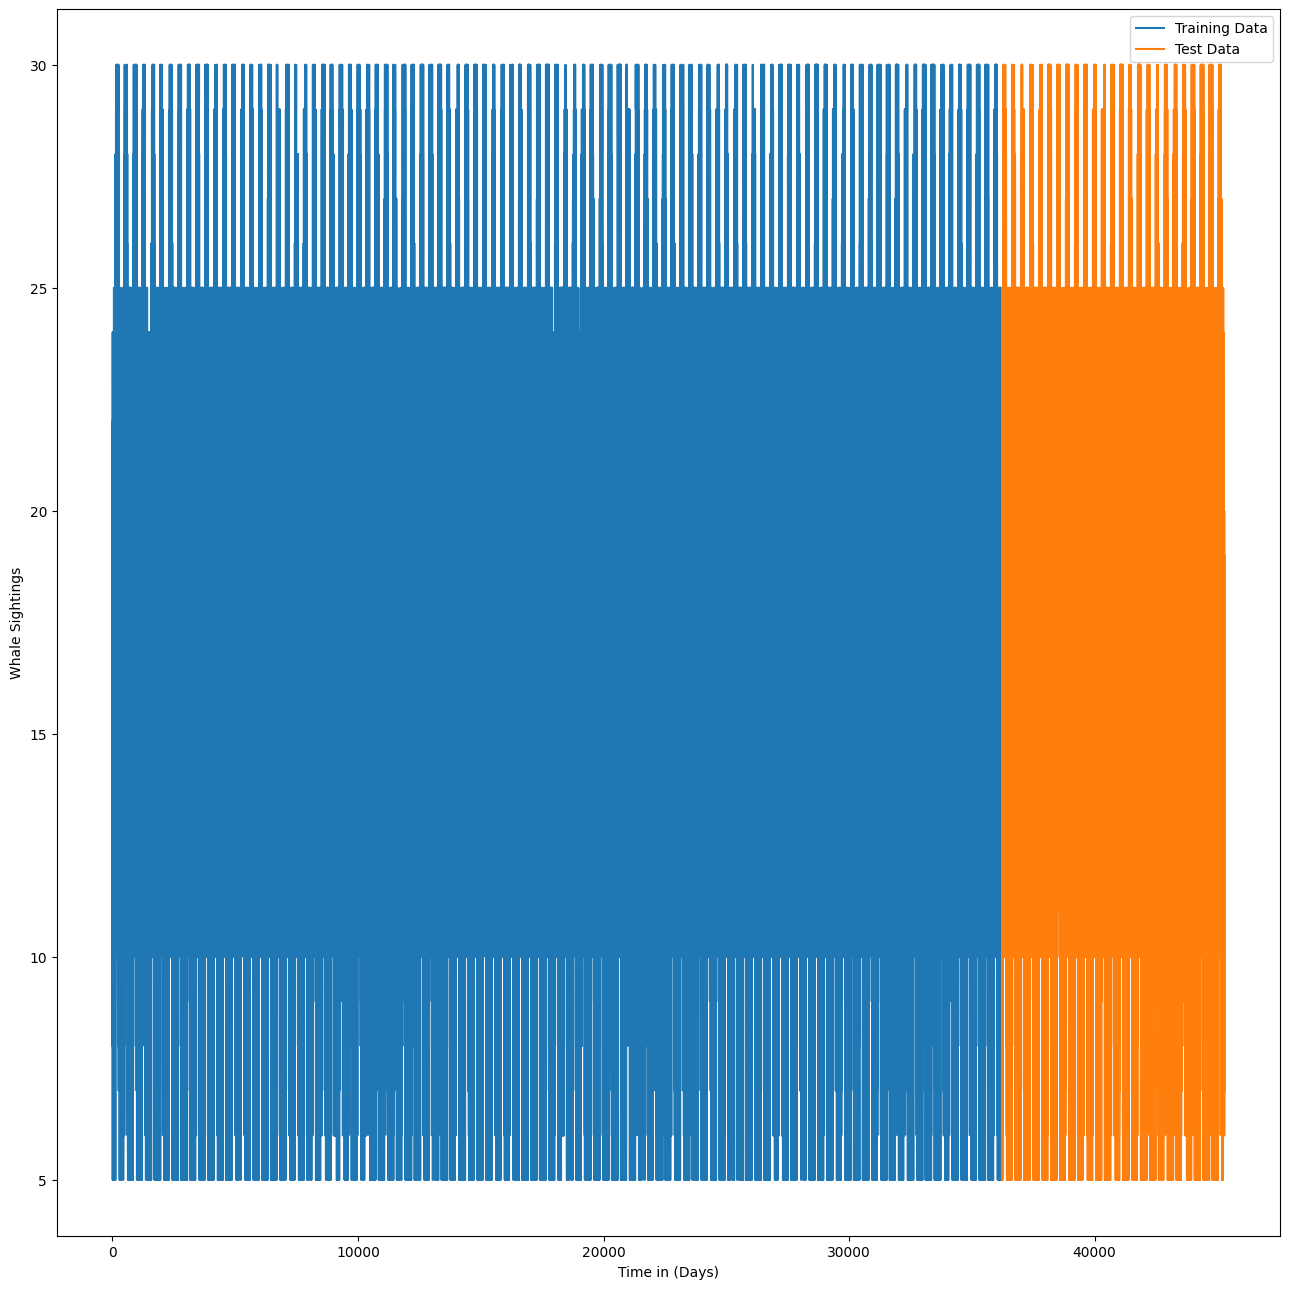

In [52]:
y = df['Whale_Sightings'].values

train_size = int(len(df) * 0.8) #(80% train, 20% test)
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

plt.figure(figsize=(13, 13))

plt.xlabel('Time in (Days)')
plt.ylabel('Whale Sightings')

plt.plot(range(len(y_train)), y_train, label='Training Data',)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Data')

plt.legend()
plt.tight_layout()
plt.show()

ACF and PACF Plots

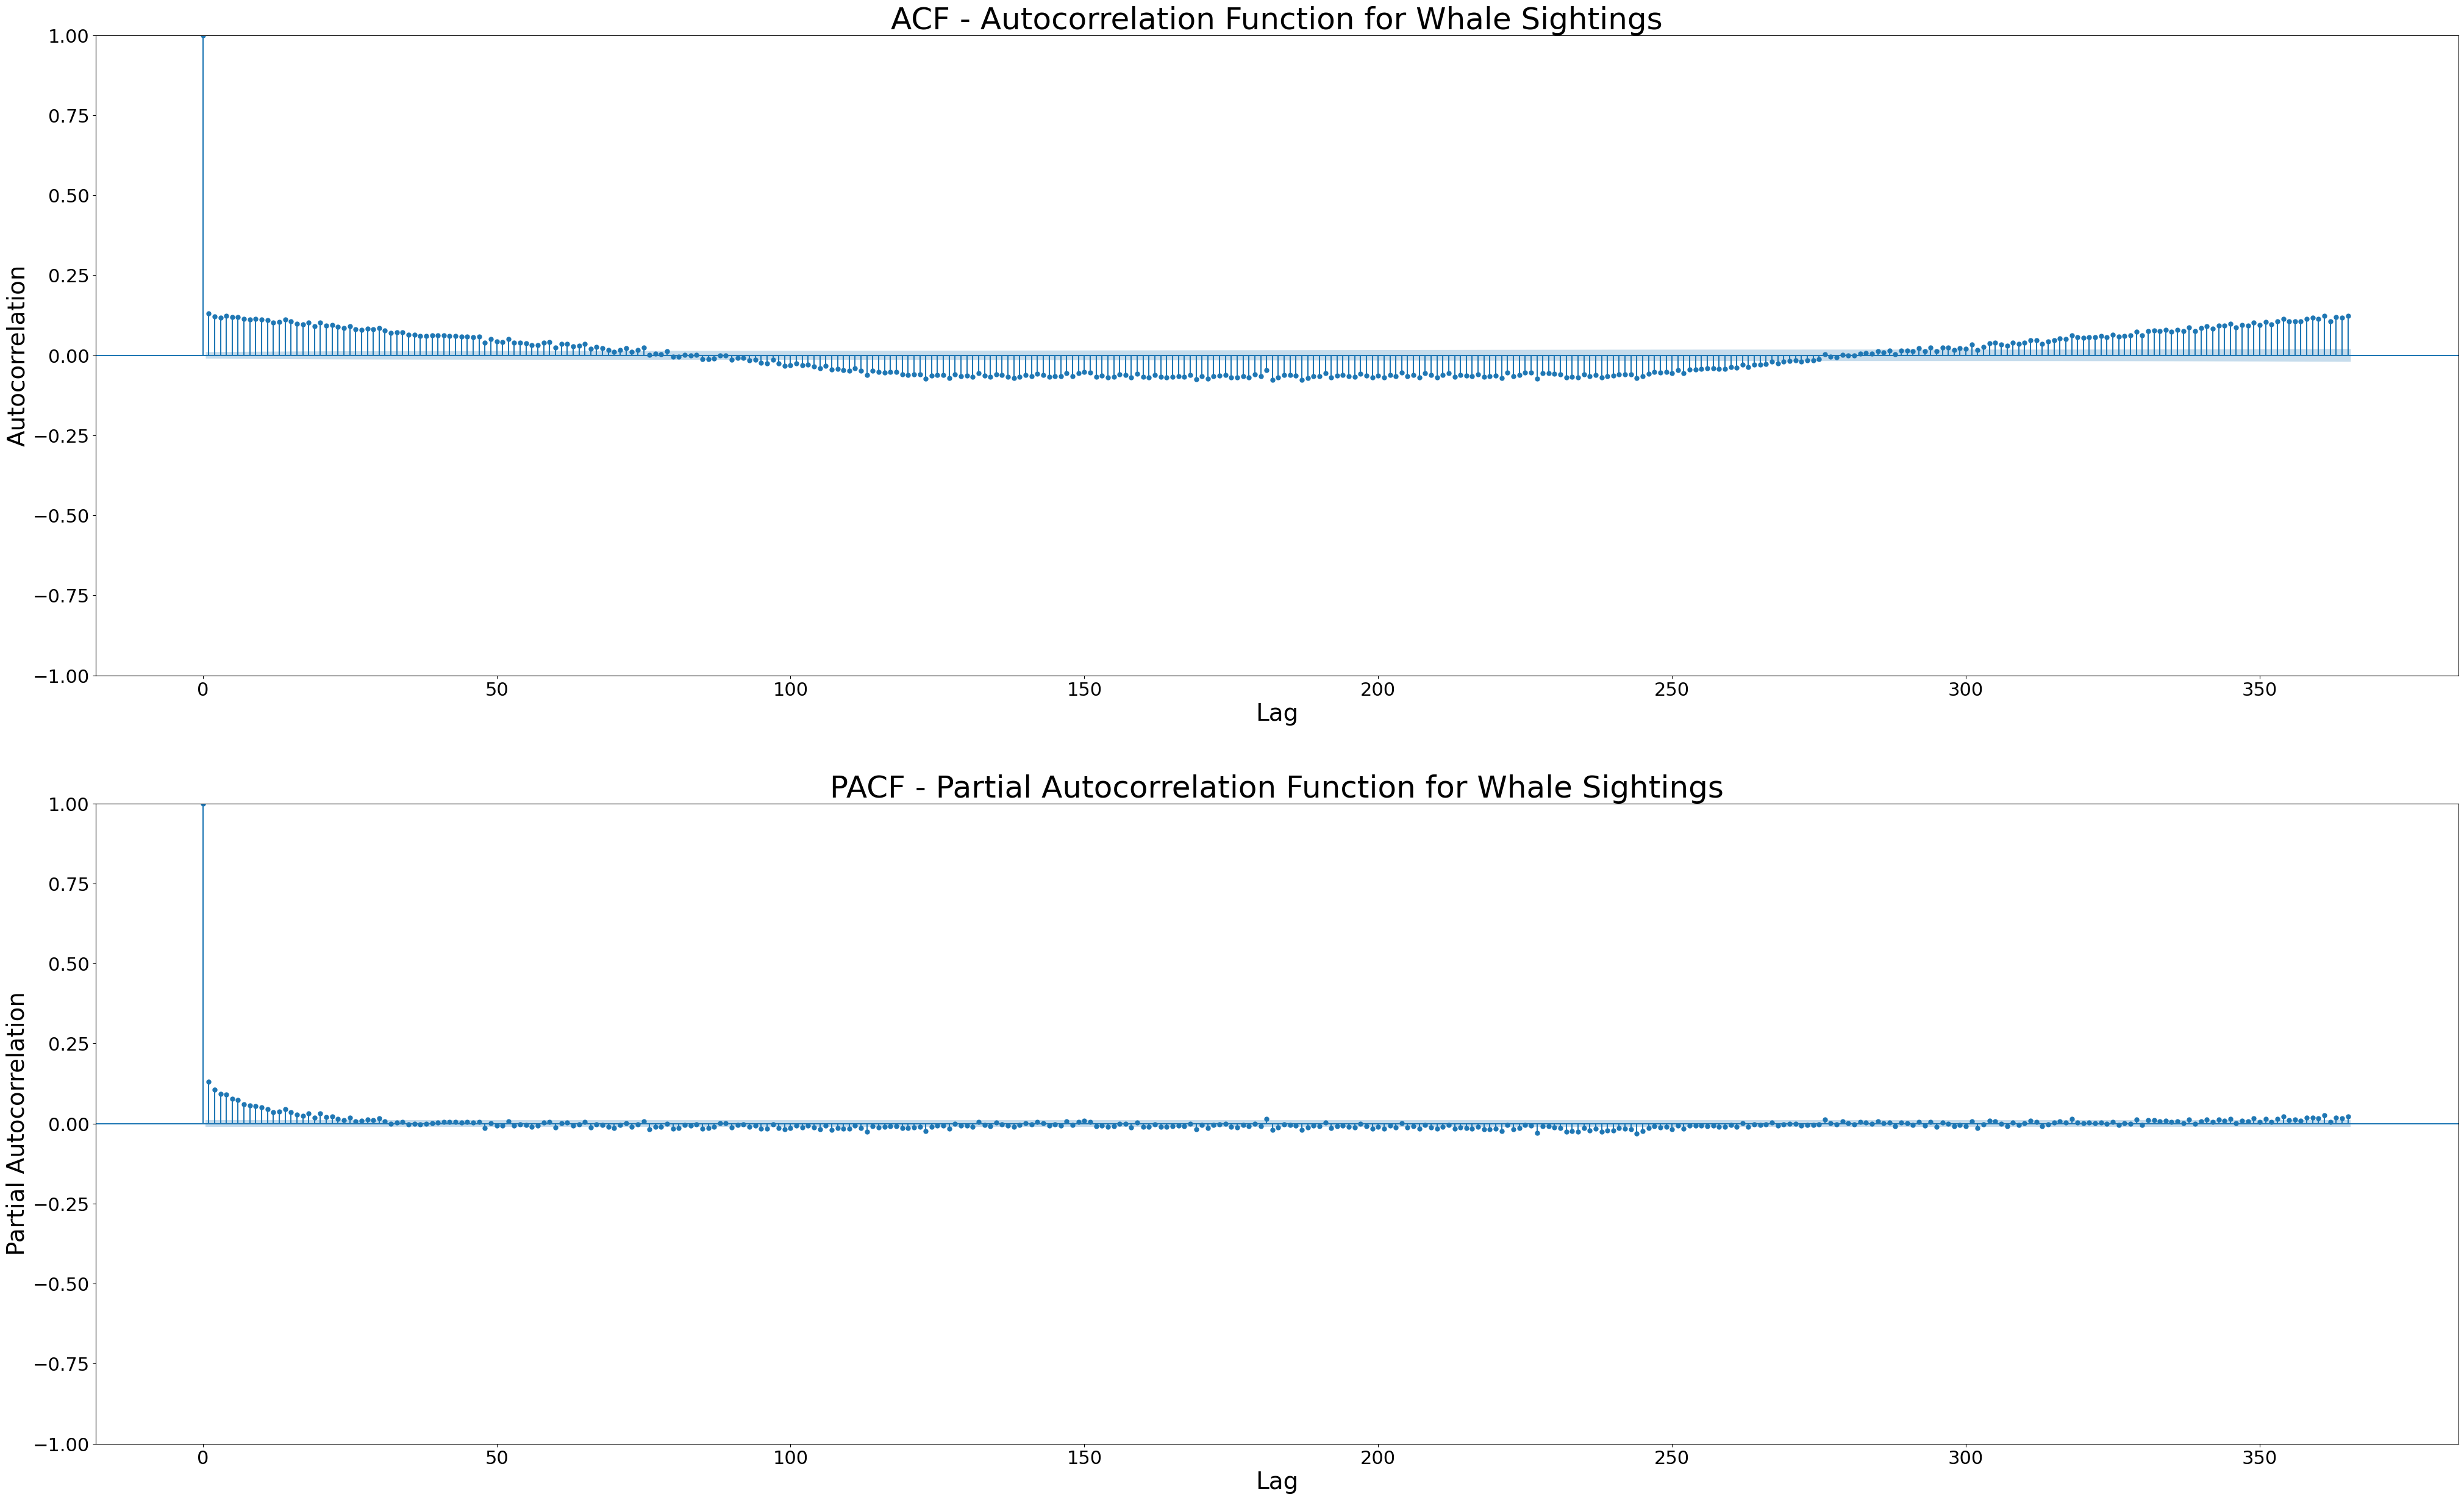

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(50, 30))

plot_acf(y_train, lags=365, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation Function for Whale Sightings", fontsize=36)
axes[0].set_xlabel("Lag", fontsize=28)
axes[0].set_ylabel("Autocorrelation", fontsize=28)
axes[0].tick_params(axis='both', which='major', labelsize=22)

plot_pacf(y_train, lags=365, ax=axes[1])
axes[1].set_title("PACF - Partial Autocorrelation Function for Whale Sightings", fontsize=36)
axes[1].set_xlabel("Lag", fontsize=28)
axes[1].set_ylabel("Partial Autocorrelation", fontsize=28)
axes[1].tick_params(axis='both', which='major', labelsize=22)

## Fitting the SARIMA Model

**SARIMAX will be employed for modeling, as SARIMA is a special case of SARIMAX. However, in this case, the exogenous variables will not be defined, hence, the model will only rely on the internal time series components (lagged values and seasonal factors) for forecasting**

In [54]:
sarima_model = SARIMAX(y_train,
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, 52),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                36232
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood             -117574.735
Date:                            Wed, 23 Apr 2025   AIC                         235159.471
Time:                                    23:27:51   BIC                         235201.952
Sample:                                         0   HQIC                        235172.981
                                          - 36232                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9812      0.002    595.481      0.000       0.978       0.984
ma.L1         -0.9243      0.003   

## Residual Analysis for the SARIMA Model

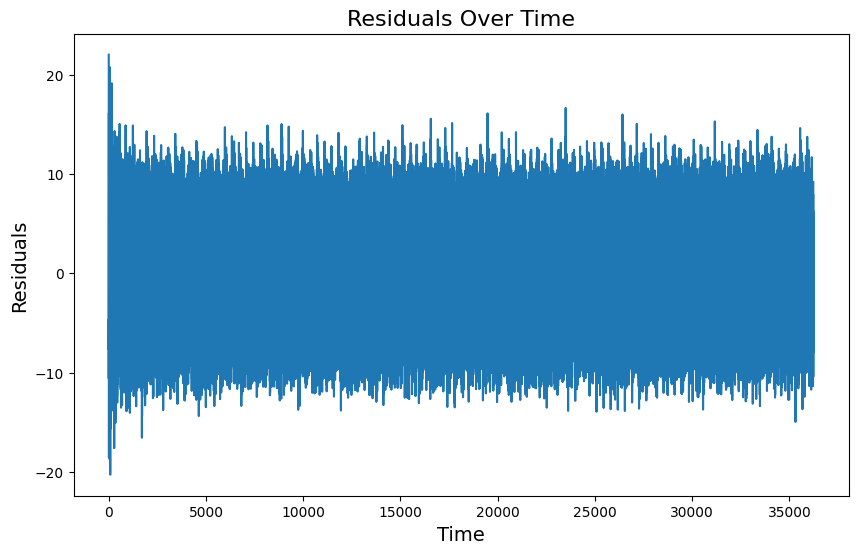

In [55]:
residuals = sarima_result.resid  

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

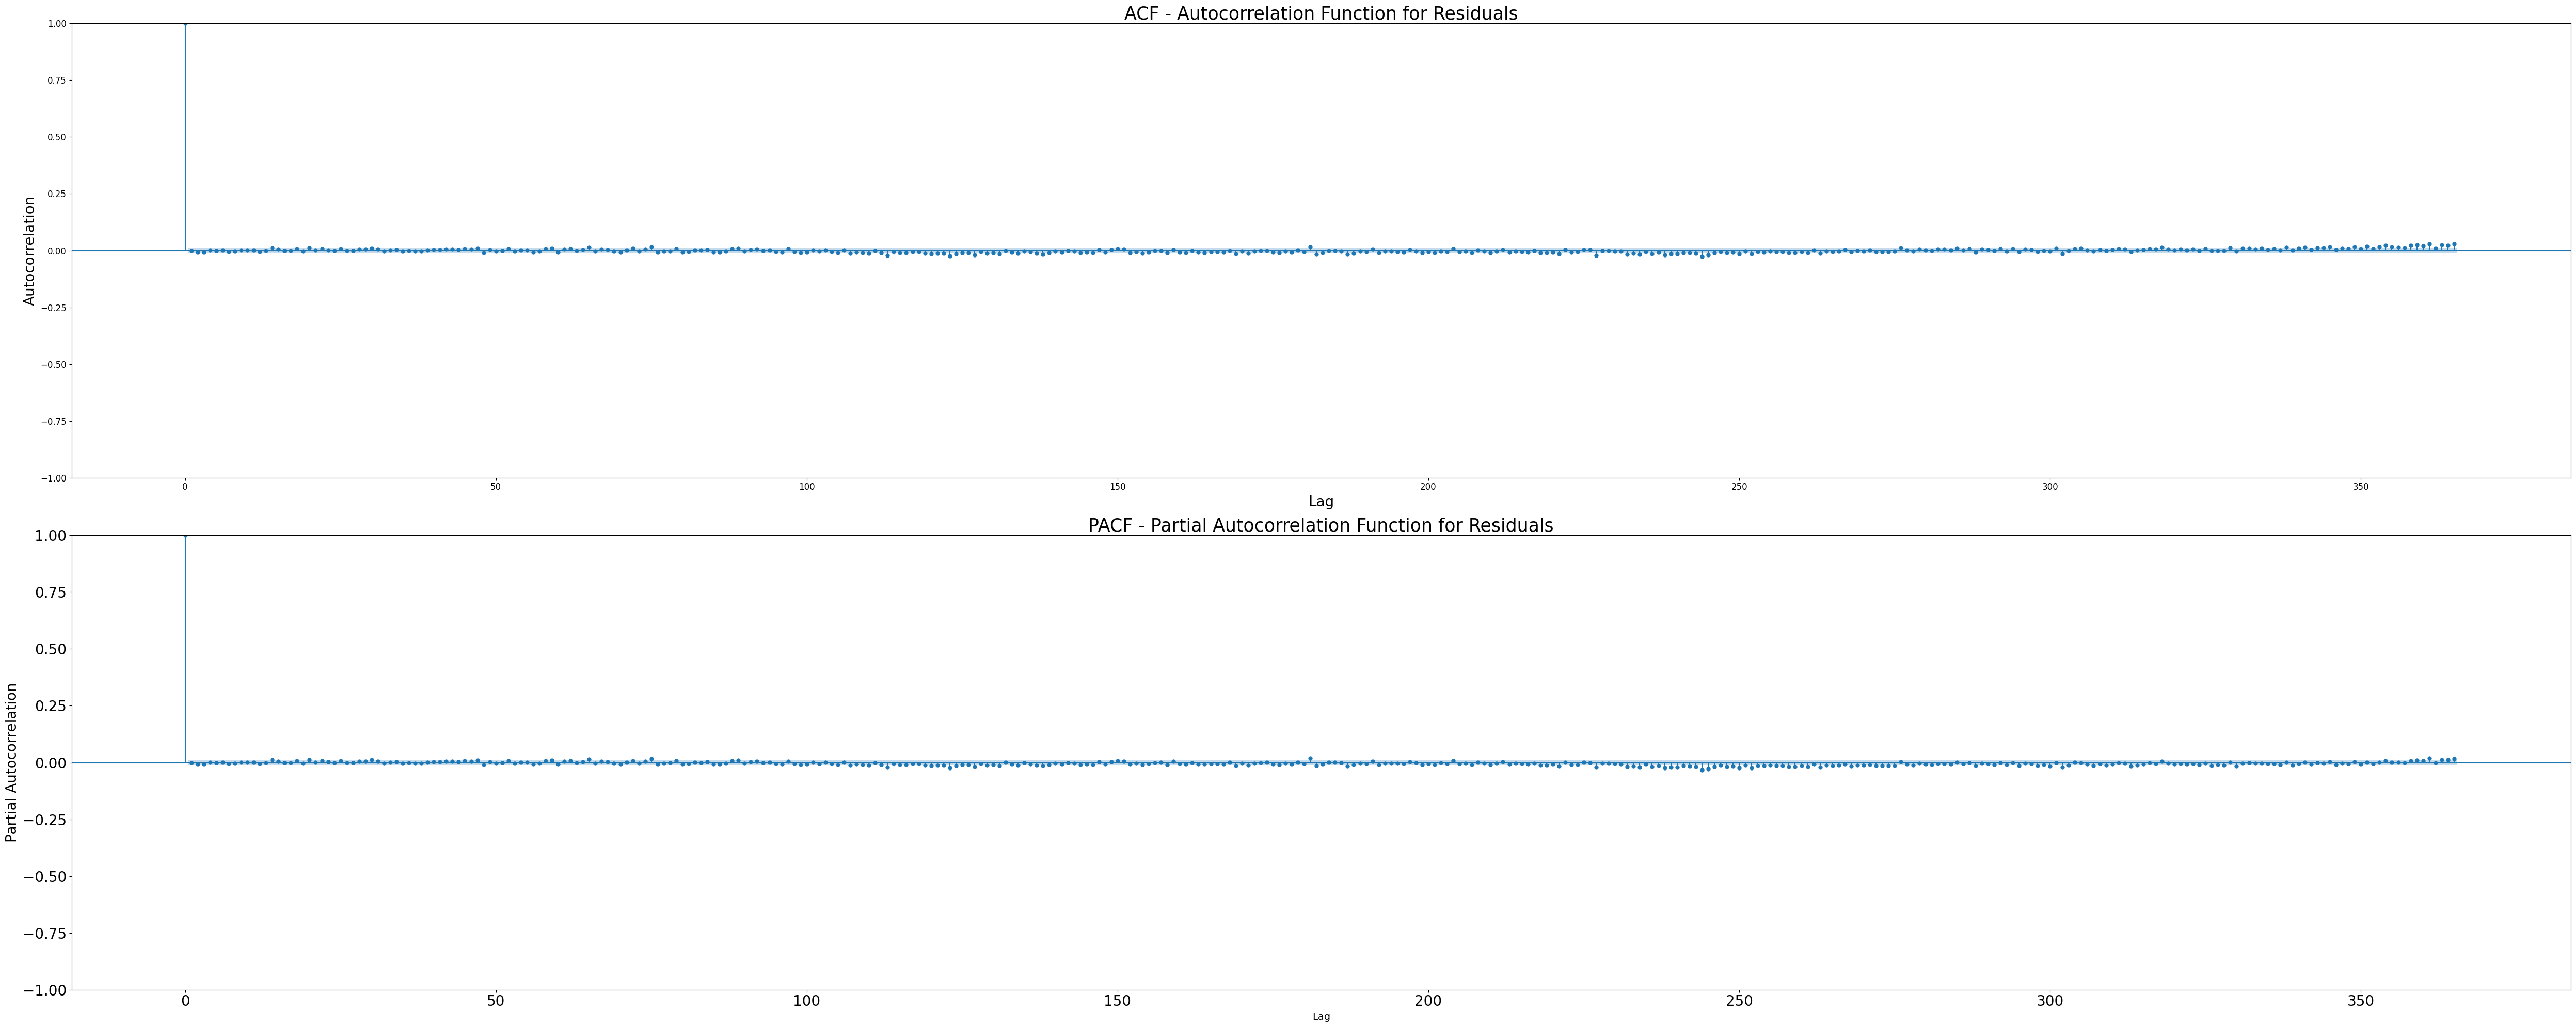

In [56]:
residuals = sarima_result.resid 

fig, axes = plt.subplots(2, 1, figsize=(50, 20))

plot_acf(residuals, lags=365, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation Function for Residuals", fontsize=25)
axes[0].set_xlabel("Lag", fontsize=20)
axes[0].set_ylabel("Autocorrelation", fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=12)

plot_pacf(residuals, lags=365, ax=axes[1])
axes[1].set_title("PACF - Partial Autocorrelation Function for Residuals", fontsize=25)
axes[1].set_xlabel("Lag", fontsize=14)
axes[1].set_ylabel("Partial Autocorrelation", fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

## Forecasting using SARIMA

Generating Forecasts for User-Specified Time Horizon

           Date  Whale_Sightings
0    2024-01-02        14.585567
1    2024-01-03        14.720432
2    2024-01-04        14.914252
3    2024-01-05        14.827528
4    2024-01-06        15.341378
...         ...              ...
9054 2048-10-16        16.212800
9055 2048-10-17        16.248895
9056 2048-10-18        16.361629
9057 2048-10-19        16.034503
9058 2048-10-20        16.489910

[9059 rows x 2 columns]


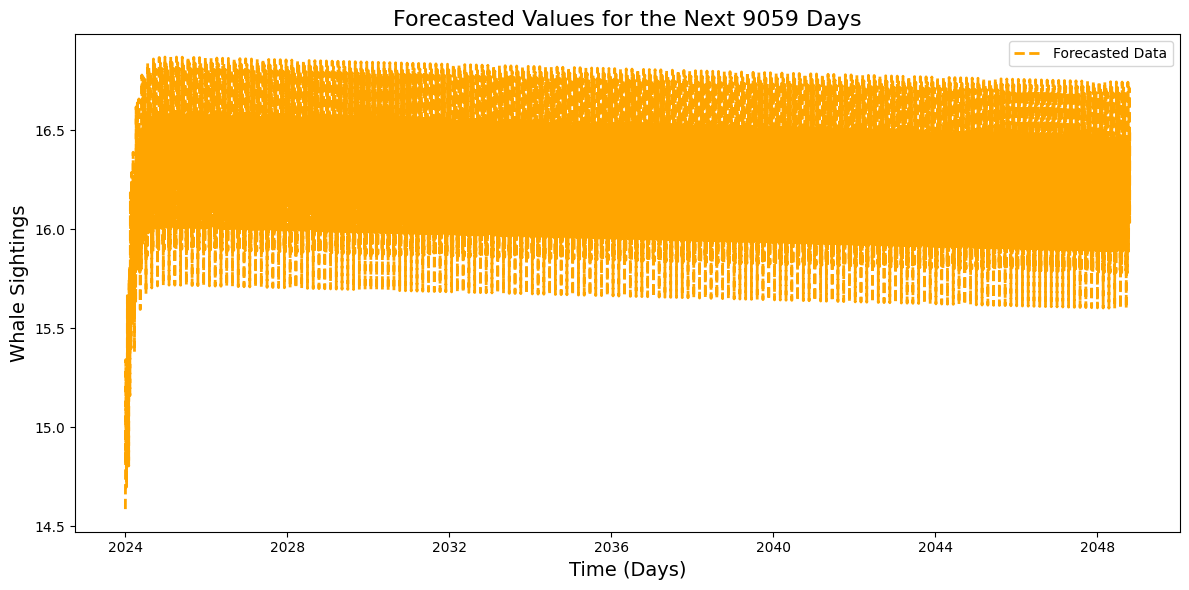

In [57]:
forecast_days = int(input("Enter the number of days to forecast: "))

last_train_date = pd.to_datetime("2024-01-01")

forecast = sarima_result.get_forecast(steps=forecast_days)
forecast_mean = forecast.predicted_mean

forecast_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Whale_Sightings': forecast_mean
})

print(forecast_table)

plt.figure(figsize=(12, 6))

plt.plot(forecast_dates, forecast_mean, label='Forecasted Data', color='orange', linestyle='--', linewidth=2)

plt.title(f'Forecasted Values for the Next {forecast_days} Days', fontsize=16)
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Whale Sightings', fontsize=14)

plt.legend()

plt.tight_layout()
plt.show()

## Performance Evaluation

In [58]:
mae = mean_absolute_error(y_test, forecast_mean)

rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))

mape = np.mean(np.abs((y_test - forecast_mean) / y_test)) * 100

r2 = r2_score(y_test, forecast_mean)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 5.4596643371563385
Root Mean Squared Error (RMSE): 6.471351308193309
Mean Absolute Percentage Error (MAPE): 44.07401722129971%
R-squared (R²): -0.006152585522594123


# SARIMAX

***SARIMAX was chosen because the time series data displays clear seasonal patterns, which are well-suited for the SARIMA model. ARMA models effectively handle non-seasonal dependencies, capturing the short-term trends in the data. Since the series is already stationary, no further differencing is needed, so the integration (I) component is set to d = 0. The key advantage of SARIMAX over SARIMA is its ability to include exogenous variables, such as environmental factors (e.g., sea temperature, ocean currents) and human activity, which can influence whale sightings. By incorporating these external factors along with the seasonal components, SARIMAX is able to model both the seasonal dynamics and the impact of external influences on whale migration, providing a more comprehensive and accurate forecasting model.***

## Exploratory Analysis for SARIMAX

Defining the Exogenous Variables

In [59]:
exog_variables = df[standardized_variables]

print(exog_variables.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45291 entries, 1900-01-01 to 2024-01-01
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  45291 non-null  float64
 1   Latitude                   45291 non-null  float64
 2   Sea_Surface_Temperature    45291 non-null  float64
 3   Chlorophyll_Concentration  45291 non-null  float64
 4   Ocean_Current              45291 non-null  float64
dtypes: float64(5)
memory usage: 2.1 MB
None


Training and Testing Split

Training set size: 36232
Test set size: 9059


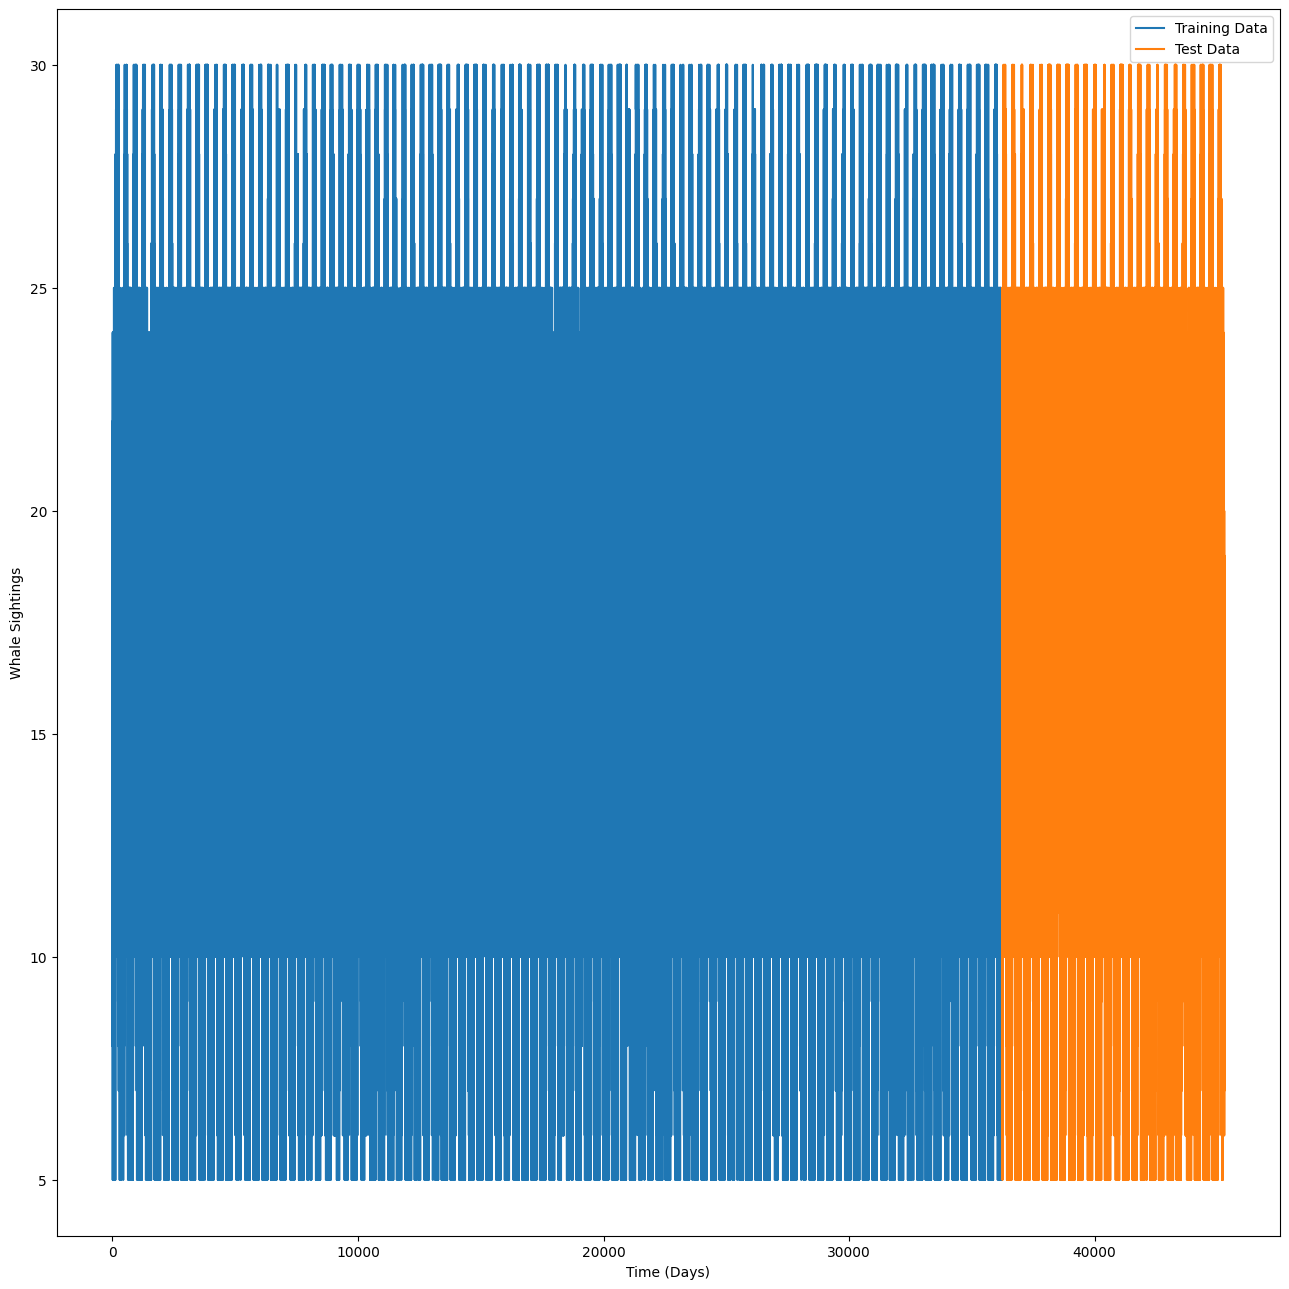

In [60]:
y = df['Whale_Sightings'].values

exog_variables = df[standardized_variables].values

train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog_variables[:train_size], exog_variables[train_size:]

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

plt.figure(figsize=(13, 13))
plt.xlabel('Time (Days)')
plt.ylabel('Whale Sightings')

plt.plot(range(len(y_train)), y_train, label='Training Data')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Data')
plt.legend()
plt.tight_layout()
plt.show()

ACF and PACF Plots

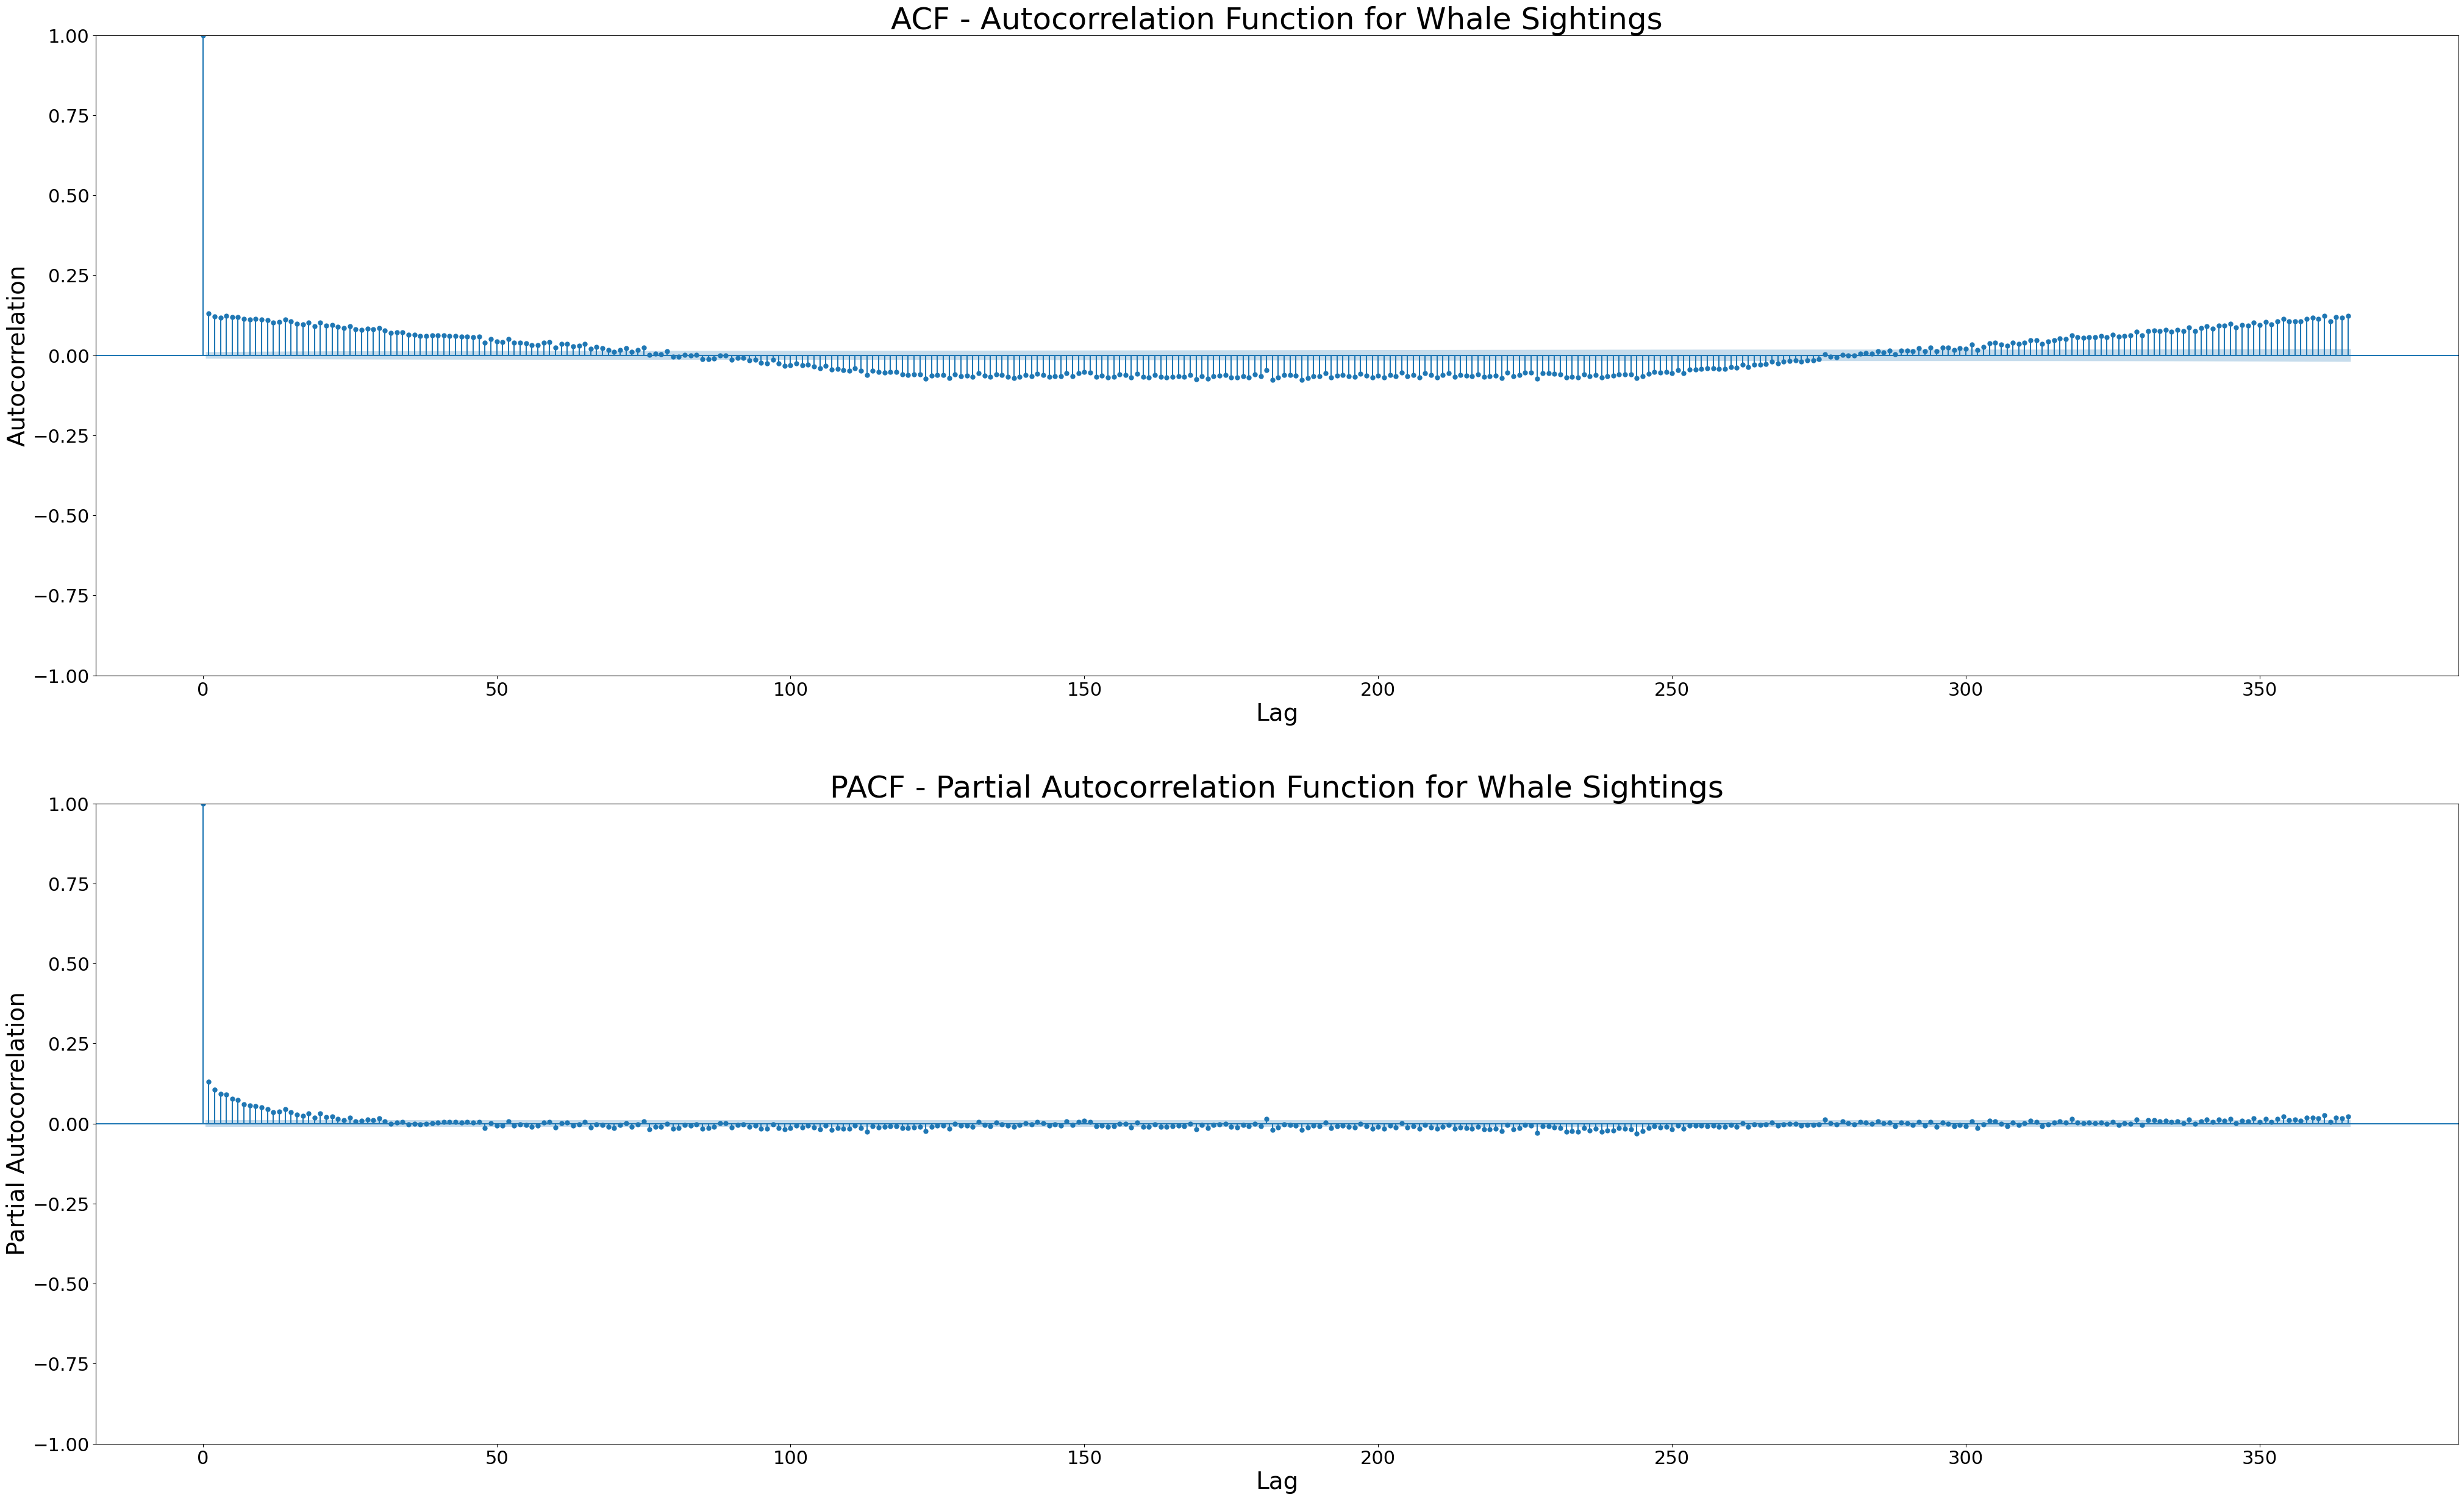

In [61]:
fig, axes = plt.subplots(2, 1, figsize=(50, 30))

plot_acf(y_train, lags=365, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation Function for Whale Sightings", fontsize=36)
axes[0].set_xlabel("Lag", fontsize=28)
axes[0].set_ylabel("Autocorrelation", fontsize=28)
axes[0].tick_params(axis='both', which='major', labelsize=22)

plot_pacf(y_train, lags=365, ax=axes[1])
axes[1].set_title("PACF - Partial Autocorrelation Function for Whale Sightings", fontsize=36)
axes[1].set_xlabel("Lag", fontsize=28)
axes[1].set_ylabel("Partial Autocorrelation", fontsize=28)
axes[1].tick_params(axis='both', which='major', labelsize=22)

## Fitting the SARIMAX Model

In [63]:
sarimax_model = SARIMAX(
    y_train,                             
    exog=exog_train,                     
    order=(1, 0, 1),                     
    seasonal_order=(1, 0, 1, 52),       
    enforce_stationarity=False,          
    enforce_invertibility=False          
)

sarimax_results = sarimax_model.fit()

print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                36232
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood             -117571.335
Date:                            Wed, 23 Apr 2025   AIC                         235162.671
Time:                                    23:42:43   BIC                         235247.633
Sample:                                         0   HQIC                        235189.691
                                          - 36232                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0343      0.032     -1.065      0.287      -0.098       0.029
x2             0.1105      0.032   

## Residual Analysis for the SARIMAX Model

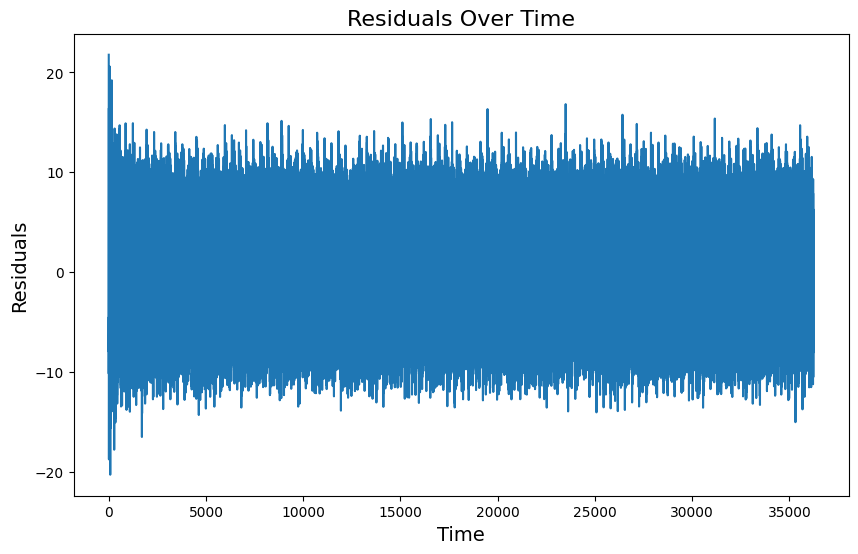

In [64]:
residuals = sarimax_results.resid  

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

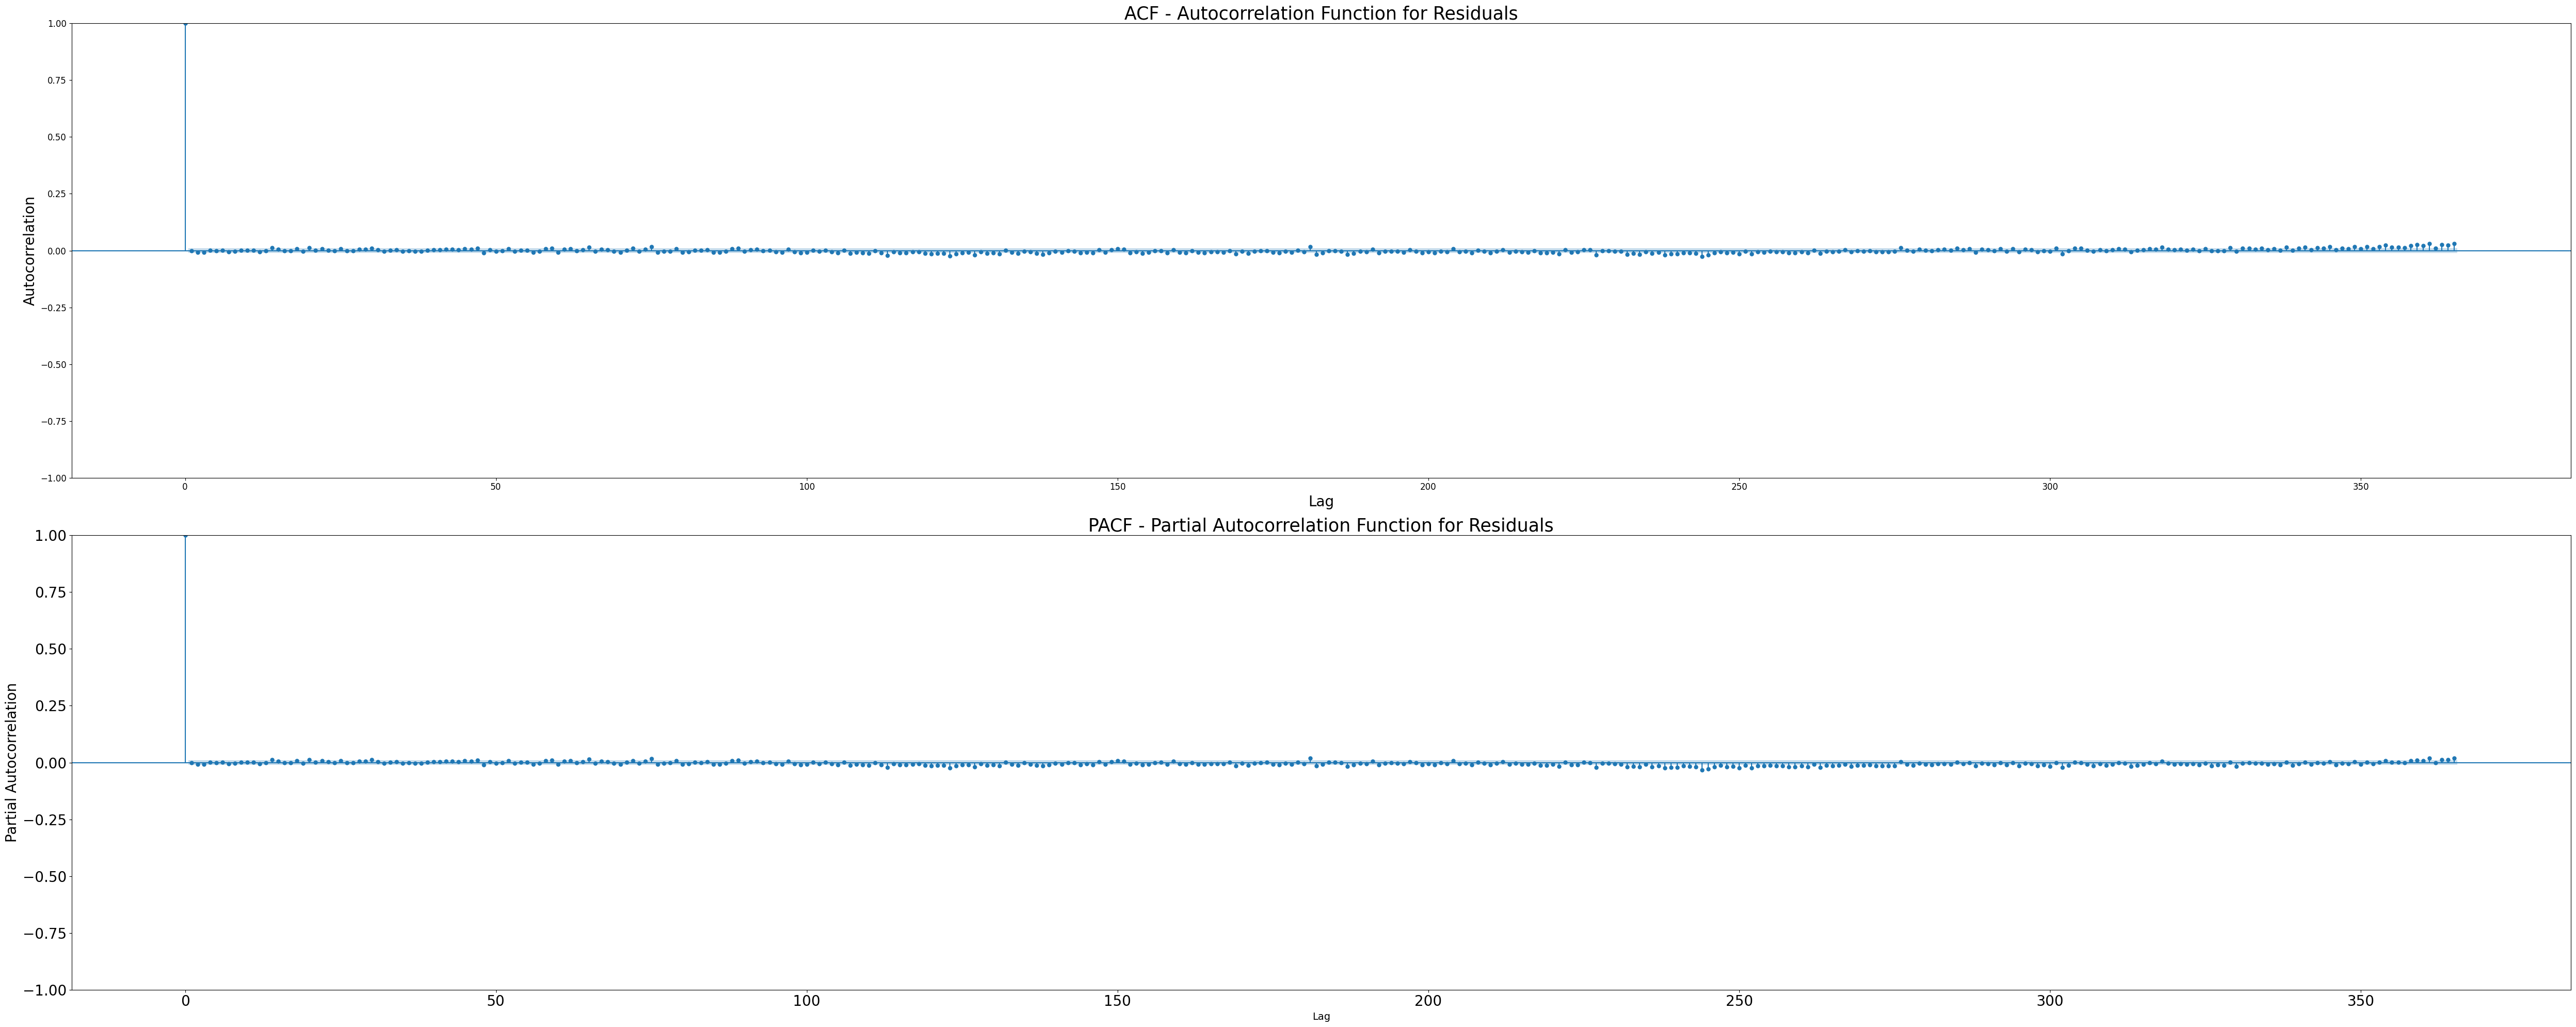

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(50, 20))

plot_acf(residuals, lags=365, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation Function for Residuals", fontsize=25)
axes[0].set_xlabel("Lag", fontsize=20)
axes[0].set_ylabel("Autocorrelation", fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=12)

plot_pacf(residuals, lags=365, ax=axes[1])
axes[1].set_title("PACF - Partial Autocorrelation Function for Residuals", fontsize=25)
axes[1].set_xlabel("Lag", fontsize=14)
axes[1].set_ylabel("Partial Autocorrelation", fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

## Forecasting using SARIMAX

Generating Forecasts for User-Specified Time Horizon

           Date  Whale_Sightings
0    2024-01-02        14.356128
1    2024-01-03        14.782510
2    2024-01-04        14.807367
3    2024-01-05        14.887892
4    2024-01-06        15.386543
...         ...              ...
9054 2048-10-16        16.318646
9055 2048-10-17        16.050385
9056 2048-10-18        16.227255
9057 2048-10-19        15.946082
9058 2048-10-20        16.601828

[9059 rows x 2 columns]


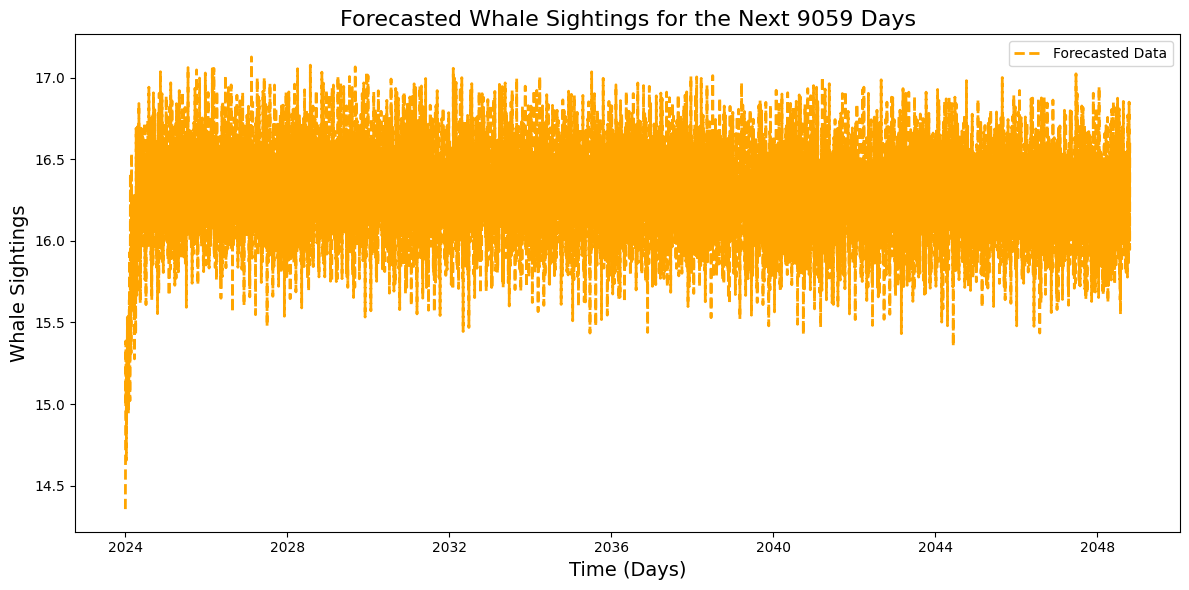

In [90]:
forecast_days = int(input("Enter the number of days to forecast: "))

last_train_date = pd.to_datetime("2024-01-01")

forecast = sarimax_results.get_forecast(steps=forecast_days, exog=exog_test[:forecast_days])
forecast_mean = forecast.predicted_mean

forecast_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Whale_Sightings': forecast_mean
})

print(forecast_table)

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast_mean, label='Forecasted Data', color='orange', linestyle='--', linewidth=2)

plt.title(f'Forecasted Whale Sightings for the Next {forecast_days} Days', fontsize=16)
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Whale Sightings', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

## Performance Evaluation

In [91]:
mae = mean_absolute_error(y_test, forecast_mean)

rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))

mape = np.mean(np.abs((y_test - forecast_mean) / y_test)) * 100

r2 = r2_score(y_test, forecast_mean)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 5.461597105695949
Root Mean Squared Error (RMSE): 6.473583093452266
Mean Absolute Percentage Error (MAPE): 44.12361483349968%
R-squared (R²): -0.006846692088318118


# VAR

## Exploratory Analysis for VAR

Standardizing Variables

In [92]:
standardized_var_variables = ['Whale_Sightings', 'Longitude', 'Latitude', 'Sea_Surface_Temperature', 'Chlorophyll_Concentration', 'Ocean_Current']

scaler = StandardScaler()

df[standardized_var_variables] = scaler.fit_transform(df[standardized_var_variables])

print(df.head())

            Latitude  Longitude  Whale_Sightings  Sea_Surface_Temperature  \
Date                                                                        
1900-01-01  1.576719  -0.247839         0.831502                -1.665660   
1900-01-02 -0.566137   1.258834        -0.868773                 1.526961   
1900-01-03  1.500491   1.136426        -1.332485                 1.507895   
1900-01-04 -0.836593  -0.054614        -1.332485                 0.488753   
1900-01-05  0.776901   1.253714         0.522361                -0.194142   

            Ocean_Current  Chlorophyll_Concentration     Moon_Phase  \
Date                                                                  
1900-01-01      -1.728435                   0.703530      Full Moon   
1900-01-02      -0.597894                  -1.454106   Last Quarter   
1900-01-03       0.248278                   0.889171       New Moon   
1900-01-04       0.338444                  -1.531165   Last Quarter   
1900-01-05      -0.036091         

Training Testing Split

Training set size: 36232
Test set size: 9059


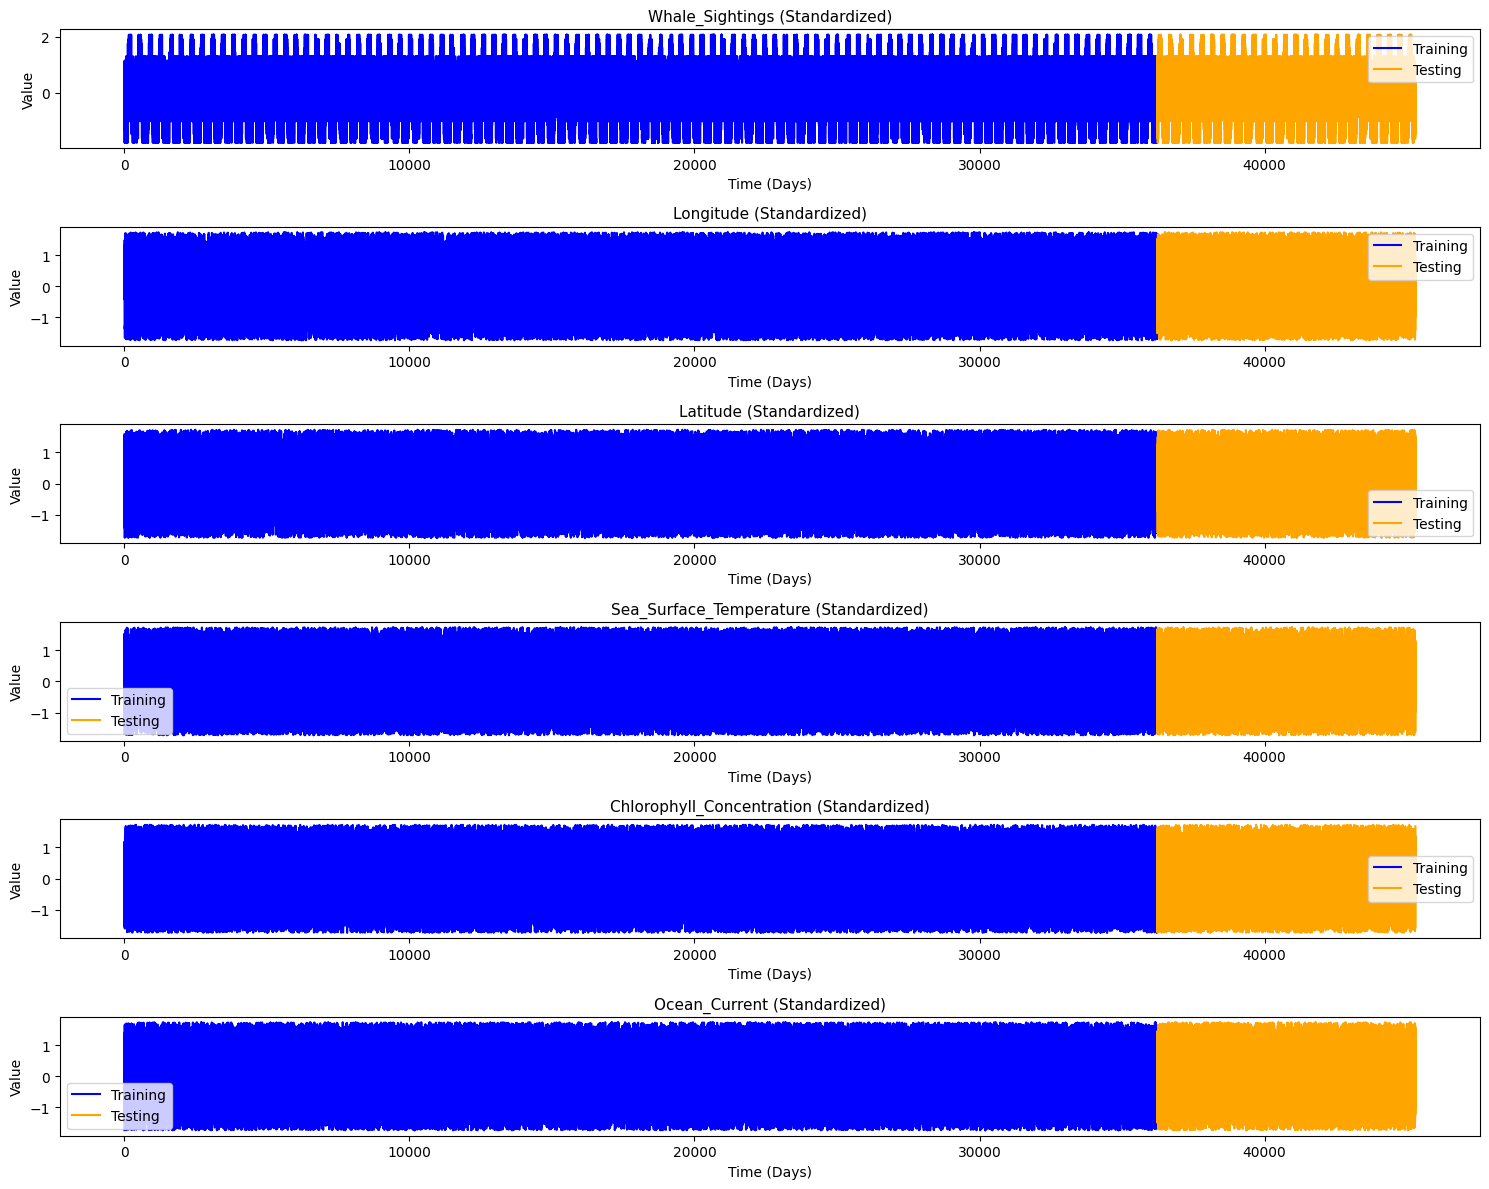

In [79]:
df.index = pd.to_datetime(df.index)

df = df.asfreq('D')

train_size = int(len(df) * 0.8)
train_data = df[standardized_var_variables].iloc[:train_size]
test_data = df[standardized_var_variables].iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

plt.figure(figsize=(15, 12))
for i, var in enumerate(standardized_var_variables):
    plt.subplot(len(standardized_var_variables), 1, i+1)
    
    plt.plot(range(len(train_data)), train_data[var], label='Training', color='blue')
    
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data[var], label='Testing', color='orange')
    
    plt.title(f'{var} (Standardized)', fontsize=11)
    plt.xlabel('Time (Days)')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

AIC BIC and HQIC Test to Determine the Optimal Lag Length

c:\Users\FLAME\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\FLAME\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\FLAME\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\FLAME\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\FLAME\AppData\Local\Programs\Python\Python313\Lib\s

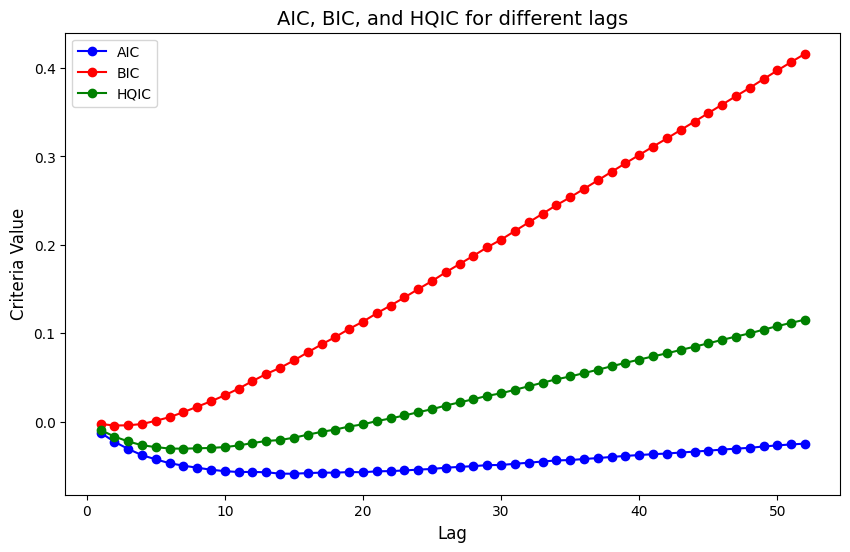

Optimal lag based on AIC: 15
Optimal lag based on BIC: 2
Optimal lag based on HQIC: 7


In [77]:
def calculate_criteria_for_lags(data, max_lag):
    aic_values = []
    bic_values = []
    hqic_values = []
    
    for lag in range(1, max_lag + 1):
        model = VAR(data)
        model_fitted = model.fit(lag)
        
        aic_values.append(model_fitted.aic)
        bic_values.append(model_fitted.bic)
        hqic_values.append(model_fitted.hqic)
    
    return aic_values, bic_values, hqic_values

max_lag = 52

aic_vals, bic_vals, hqic_vals = calculate_criteria_for_lags(train_data, max_lag)

plt.figure(figsize=(10, 6))
lags = range(1, max_lag + 1)

plt.plot(lags, aic_vals, label='AIC', color='blue', marker='o')
plt.plot(lags, bic_vals, label='BIC', color='red', marker='o')
plt.plot(lags, hqic_vals, label='HQIC', color='green', marker='o')

plt.title('AIC, BIC, and HQIC for different lags', fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Criteria Value', fontsize=12)
plt.legend()
plt.show()

optimal_aic_lag = aic_vals.index(min(aic_vals)) + 1
optimal_bic_lag = bic_vals.index(min(bic_vals)) + 1
optimal_hqic_lag = hqic_vals.index(min(hqic_vals)) + 1

print(f'Optimal lag based on AIC: {optimal_aic_lag}')
print(f'Optimal lag based on BIC: {optimal_bic_lag}')
print(f'Optimal lag based on HQIC: {optimal_hqic_lag}')

## Forecasting Using VAR 

In [95]:
forecast_input = train_data.values[-lag:]  # last 'lag' rows as initial input
n_forecast_days = 9059

forecast = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Step 6: Inverse transform (unstandardize) the forecast
forecast_unscaled = scaler.inverse_transform(forecast)

# Step 7: Create DataFrame with dates
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_forecast_days, freq='D')
forecast_df = pd.DataFrame(forecast_unscaled, index=forecast_index, columns=standardized_var_variables)

# Step 8: View result
print(forecast_df.head())
print(forecast_df.tail())

            Whale_Sightings  Longitude  Latitude  Sea_Surface_Temperature  \
2024-01-02        -0.276902   0.047728 -0.042394                -0.035190   
2024-01-03        -0.295241  -0.012884 -0.070930                 0.026435   
2024-01-04        -0.352567   0.003730 -0.011697                 0.033646   
2024-01-05        -0.288732  -0.023071 -0.002829                -0.022624   
2024-01-06        -0.261035  -0.024253  0.015827                 0.005703   

            Chlorophyll_Concentration  Ocean_Current  
2024-01-02                  -0.009274       0.000922  
2024-01-03                  -0.018752       0.037469  
2024-01-04                   0.049363       0.015129  
2024-01-05                   0.015640      -0.022984  
2024-01-06                  -0.006659       0.023428  
            Whale_Sightings  Longitude  Latitude  Sea_Surface_Temperature  \
2048-10-16        -0.003188   0.001212    0.0039                 0.003653   
2048-10-17        -0.003188   0.001212    0.0039     

## Fitting the VAR Model in Accordance to the Optimum Lag

In [93]:
lag = 7
model = VAR(train_data)
model_fitted = model.fit(lag)

## Performance Evaluation

In [94]:
mae_scores = {}
rmse_scores = {}
mape_scores = {}
r2_scores = {}

for var in standardized_var_variables:
    y_true = test_data[var]
    y_pred = forecast_df[var]
    
    mae_scores[var] = mean_absolute_error(y_true, y_pred)
    rmse_scores[var] = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_scores[var] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2_scores[var] = r2_score(y_true, y_pred)

# Print metrics
print("Evaluation Metrics:")
for var in standardized_var_variables:
    print(f"\n{var}:")
    print(f"  MAE:  {mae_scores[var]:.4f}")
    print(f"  RMSE: {rmse_scores[var]:.4f}")
    print(f"  MAPE: {mape_scores[var]:.2f}%")
    print(f"  R²:   {r2_scores[var]:.4f}")


Evaluation Metrics:

Whale_Sightings:
  MAE:  0.8423
  RMSE: 0.9973
  MAPE: nan%
  R²:   -0.0002

Longitude:
  MAE:  0.8630
  RMSE: 0.9974
  MAPE: nan%
  R²:   -0.0000

Latitude:
  MAE:  0.8626
  RMSE: 0.9976
  MAPE: nan%
  R²:   -0.0004

Sea_Surface_Temperature:
  MAE:  0.8603
  RMSE: 0.9942
  MAPE: nan%
  R²:   -0.0003

Chlorophyll_Concentration:
  MAE:  0.8712
  RMSE: 1.0037
  MAPE: nan%
  R²:   -0.0003

Ocean_Current:
  MAE:  0.8701
  RMSE: 1.0018
  MAPE: nan%
  R²:   -0.0000
